# <center> 教学案例4：RAG技术实战
# <center> Part 2.LangChain RAG系统开发基础

## 一、回顾 Naive RAG 基础架构

&emsp;&emsp;目前企业的主要需求是希望大模型能够结合私有的数据进行问答、工作流构建、智能数据分析等等一系列的智能化应用。当企业有一个偌大的知识库，当想从该知识库中去检索最相关的内容时，最简单的方法是：接收到一个查询（Query），就直接在知识库中进行搜索。这种做法其实是可行的，但存在两个关键的问题：

1. 假设提问的`Query`的答案出现在一篇文章中，去知识库中找到一篇与用户输入相关的文章是很容易的，但是我们将检索到的这整篇文章直接放入`Prompt`中并不是最优的选择，因为其中一定会包含非常多无关的信息，而无效信息越多，对大模型后续的推理影响越大。

2. 任何一个大模型都存在最大输入的`Token`限制，一个流程中可能涉及多次检索，每次检索都会产生相应的上下文，无法容纳如此多的信息。

&emsp;&emsp;因此，我们需要一种方法，能够从知识库中检索出最相关的信息，并将其作为上下文输入到`Prompt`中，从而提高大模型回答的准确性和相关性。

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404101639353.png" width=80%></div>

&emsp;&emsp;解决上述两个问题的方式是：把存放着原始数据的知识库（`Knowledge`）中的每一个`raw data`，切分成一个一个的小块，这些小块可以是一个段落，也可以是数据库中某个索引对应的值。这个切分过程被称为“分块”（`chunking`），如下述流程所示：

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404101759694.png" width=80%></div>

&emsp;&emsp;以第一个原始数据为例（`raw data 1`），通过一些特定的方法进行切分，一个完整的内容会被分割成 `chunk1 ~ chunk4`。采取相同的方法，继续对`raw data 2`、`raw data 3`直至`raw data n`进行切分。完成这一过程后，我们最终得到的是一个充满分块数据（`chunks`）的新的知识库（`repository`），其中每一项都是一个单独的`chunk`。例如，如果原始文档共有10个，那么经过切分，可能会产生出100个chunks。

&emsp;&emsp;完成这一转化后，当再次接收到一个查询（`Query`）时，就会在更新后的知识库（`repository`）中进行搜索，这时检索的范围就不再是某个完整的文档，而是其中的某一个部分，返回的是一个或多个特定的`chunk`，这样返回的信息量就会更小且更精确。随后，这些被检索到的`chunk`会被加入到`Prompt`中，作为上下文信息与用户原始的`Query`共同输入到大模型进行处理，以生成最终的回答。

&emsp;&emsp;在上述将原始数据（raw data）转化为chunk的过程中，就会包含构建RAG的第一部分开发工作：这包括如果做数据清洗，如去除停用词、标点符号等。此外，还涉及如何选择合适的`split`方法来进行数据切分的一系列技术。

&emsp;&emsp;接下来面临的问题是，尽管所有数据已经被切割成一个个`chunk`，其存储形式还是以字符串形式存在，如果想从`repository`中匹配到与输入的query相关的chunks，比较两句话是否相似，看一句话中相同字有几个，这显然是行不通的。我们需要获取的是句子所蕴含的深层含义，而非仅仅是表面的字面相似度。因此，大家也能想到，在NLP中去计算文本相似度的有效的方法就是Embedding，即将这些chunks转换成向量（vector）形式。

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20231027153920966.png" alt="image-20231027153920966" style="zoom:77%;" />

&emsp;&emsp;最终这个流程如下所示：

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404101823060.png" width=80%></div>

&emsp;&emsp;在这个流程中，会先将用户输入的 `Query` 转化成 `Vector`，然后再去与知识库中的向量进行相似度比较，检索出相似的`Vector`，最终返回其对应的`Chunk`（字符串形式的文本），再执行后续的流程。所以在这个过程中，就会产生构建RAG的第二部分的开发工作：如果将`chunk`转化成`Vector`及以何种形式进行存储。同时，我们要考虑的是：如何去计算向量之间的相似度？如果去和知识库中的向量一个一个比较，这个时间复杂度是非常高的，那么其解决办法又是什么呢？我们继续看下述流程：


<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404101838975.png" width=80%></div>

&emsp;&emsp;如上所示，解决搜索效率和计算相似度优化算法的答案就是：向量数据库。同时也产生了构建RAG的第三部分工作：我们要去了解和学习如何选择、使用向量数据库。因此，一个基础的RAG架构会只要包含以下几方面的开发工作：

1. 如何将原始数据转化成`chunks`；
2. 如何将`chunks`转化成`Vector`；
3. 如何选择计算向量相似度的算法；
4. 如何利用向量数据库提升搜索效率；
5. 如何把找到的`chunks`与原始`query`拼接在一起，产生最终的`Prompt`；

## 二、LangChain RAG API详解

&emsp;&emsp;在`LangChain`框架中，`RAG`作为一个非常重要且关键的模块独立存在，如下图所示：https://python.langchain.com/docs/integrations/retrievers/

<div align=center><img src="https://muyu20241105.oss-cn-beijing.aliyuncs.com/images/202507071040807.png" width=80%></div>

&emsp;&emsp;针对我们在上一小节分析的`RAG`流程，每一个子流程中，`LangChain`都提供了多种较为通用的实现方法，这包括如何将不同来源、不同形式的数据切分成一个个小块，如何使用Embedding模型做向量化，如何将向量存储进向量数据库中，以及提供了快速检索的优化算法。每一环节设计的基础技术，都作为一个独立的抽象模块存在，而将各个环节像`Chains`一样串流起来进行数据交换，形成一个完整的`RAG`系统，`LangChain`抽象了一个所谓的`data connection`数据处理流，如下图所示：

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404031721966.png" width=80%></div>

&emsp;&emsp;`data connecting` 是`Langchain`框架原生的数据处理流，`RAG`是涉及多个处理环节的一个架构，它不是个体，而是一个整体，所以虽然不同环节、不同模块间所做的事情是不一样的，但它们之间是需要链接的，需要进行数据的交换，那这一部分工作，就是交给`data connection`来统一管理。例如，在上述流程中，"Source"阶段指的是附加的数据库，它能够整合来自不同数据源的信息。通过"Load"组件，这些数据可以被统一管理。"Transform"组件则负责进行数据切分等一系列前文提到的构建RAG所需的开发任务，提供了各种不同的解决方案。

&emsp;&emsp;因此，学习`LangChain`中`RAG`的构建过程我们更建议：第一步学流程，第二步学关键点，第三步学每一环节的具体技术，第四步不断地扩展优化，从基础`RAG`到进阶`RAG`。所以接下来，我们就按照`LangChain`的`data conncetiong`流程，逐步拆解每一模块的关键技术点进行讲解和实践，最终跑通这个`RAG`流程。

- LangChain接入OpenAI、DeepSeek、DashScope流程

- 创建.env文件并写入配置：

In [ ]:
!echo "OPENAI_API_KEY=sk-XXXXX(自己的API-KEY)" > /content/.env
!echo "BASE_URL=https://dashscope.aliyuncs.com/compatible-mode/v1" >> /content/.env
!echo "MODEL=qwen-plus" >> /content/.env
!echo "LANGSMITH_TRACING=true" > /content/.env
!echo "LANGSMITH_API_KEY=lsv2_XXXXX(自己的API-KEY)" >> /content/.env
!echo "LANGSMITH_PROJECT=langraph_studio_chatbot" >> /content/.env
!echo "OPENWEATHER_API_KEY=sk-XXXXX(自己的API-KEY)" > /content/.env
!echo "DASHSCOPE_API_KEY=sk-XXXXX(自己的API-KEY)" > /content/.env

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250708165705944.png" alt="image-20250708165705944" style="zoom:50%;" />

- 安装相关的依赖库：

In [ ]:
! pip install langchain python-dotenv langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 2.9 MB/s eta 0:00:00


- 测试调用：

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv(override=True)

True

In [ ]:
!pip install -U langchain-qwq

In [ ]:
from langchain_qwq import ChatQwQ

model = ChatQwQ(
    model="qwen-plus",
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
)

In [ ]:
question = "你好，请你介绍一下你自己。"

result = model.invoke(question)
print(result.content)

你好！我是Qwen，是阿里巴巴集团旗下的通义实验室自主研发的超大规模语言模型。我可以帮助你回答问题、创作文字，比如写故事、写公文、写邮件、写剧本、逻辑推理、编程等等，还能表达观点，玩游戏等。我支持多种语言，包括但不限于中文、英文、德语、法语、西班牙语等。如果你有任何问题或需要帮助，随时告诉我！


### 1. Source 与 data loaders功能实现

&emsp;&emsp;`Source`概念指的是`RAG`架构中所外挂的知识库。正如我们之前所讨论的，因为大模型的原生能力很强，所以它可以识别多种不同的类型的原始数据而不用做额外的处理，而且在实际场景中，私有数据通常也并不是单一的，可以来自多种不同的形式，可以是上百个.csv文件，可以是上千个.json文件，也可以是上万个.pdf文件，同时如果对接到具体的业务，可以是某一个业务流程外放的API，可以是某个网站的实时数据等多种情况。

&emsp;&emsp;所以`LangChain`首先做的就是：将常见的数据格式和数据来源使用`LangChain`的规范，抽象出一个一个的单独的集成模块，称为文档加载器（`Document loaders`），用于快速加载某种形式下的文本数据。如下图所示：

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404031755305.png" width=60%></div>

&emsp;&emsp;这意味着，我们可以通过调用`LangChain`抽象好的方法直接处理私有数据，无需手动编写中间的处理流程，并且每一种文档的加载器，在`LangChain`官方文档中都有基本的调用示例供我们快速上手使用，具体位置如下：https://python.langchain.com/docs/integrations/document_loaders/

<div align=center><img src="https://muyu20241105.oss-cn-beijing.aliyuncs.com/images/202507071045781.png" width=60%></div>

&emsp;&emsp;各个不同类型的文档加载器经过`langChain`的高度封装后使用起来并不会很复杂，可以直接调用`load_documents`方法，传入文件路径，就可以加载出对应的文档。这里我们进行几种不同类型的文档加载，并查看加载后的文档内容。

&emsp;&emsp;在LangChain技术生态中，**文档加载（Document Loaders）\**是支撑检索增强生成（RAG）流程的核心组件之一。LangChain已原生集成了丰富的加载器模块，覆盖\**本地文件、在线网页、数据库、云存储、第三方应用及多媒体资源**等多样化数据来源，极大降低了异构知识接入的开发成本。

&emsp;&emsp;总体来看，这些加载器可分为七大类：本地文件加载、网页抓取、API集成、数据库连接、云端存储、特定格式解析以及自定义扩展。每类加载器均封装了数据读取、文档分块、元数据生成等常用操作，开发者只需在配置中指定路径或凭据，即可将不同来源的内容标准化为LangChain可处理的**Document对象**，为后续Embedding、检索和问答链条提供高质量的输入。

&emsp;&emsp;这一体系不仅支持通用场景（如PDF阅读、网页爬取），也覆盖了Notion、Slack、Confluence、Google Drive等现代企业常用的云应用，使LangChain成为目前RAG系统中**文档接入能力最丰富的开源框架**之一。


&emsp;&emsp;下表列举了LangChain已集成的**部分典型加载器**，按类别分类展示（并非穷尽所有）：

| 分类                  | 加载器名称（部分示例）                                       |
| --------------------- | ------------------------------------------------------------ |
| 本地文件加载器        | TextLoader, CSVLoader, PDFLoader, UnstructuredLoader, JSONLoader, Docx2txtLoader |
| 网页加载器            | WebBaseLoader, SitemapLoader, TrafilaturaLoader, RecursiveUrlLoader |
| API/第三方数据加载器  | NotionDBLoader, SlackLoader, ConfluenceLoader, GitHubIssuesLoader, GoogleDriveLoader |
| 数据库加载器          | SQLDatabaseLoader, PandasDataFrameLoader, FAISSLoader, MilvusLoader |
| 云存储加载器          | S3DirectoryLoader, GCSDirectoryLoader, AzureBlobStorageLoader |
| 多媒体/特定格式加载器 | YouTubeLoader, AudioLoader, EPubLoader, EverNoteLoader       |
| 自定义/通用加载器     | DirectoryLoader, BSHTMLLoader, iFixitLoader                  |

#### 1.1 在线文档加载流程

&emsp;&emsp;我们以`Wikipedia`为示例，维基百科大家都比较熟悉，是一个多语言免费在线百科全书，当`LangChain`集成了以后，就可以按照文档说明直接调用。https://python.langchain.com/docs/integrations/document_loaders/wikipedia/

<div align=center><img src="https://muyu20241105.oss-cn-beijing.aliyuncs.com/images/202507071050775.png" width=60%></div>

&emsp;&emsp;按要求安装项目依赖。

In [ ]:
! pip install -U langchain_community wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=442693732a68d006949abab646a9606b069cd9edfb9f117f15e97fb843fd463d
  Stored in directory: /root/.cache/pip/wheels/63/47/7c/a9688349aa74d228ce0a9023229c6c0ac52ca2a40fe87679b8
Successfully built wikipedia


&emsp;&emsp;在构造方法中能非常明确的看到可以在调用时支持自定义的参数，再结合官方的说明文档，可整理出如下有效信息：

- **query** ：用于在维基百科中查找文档的自由文本
- **可选 lang** ：默认=“en”。用它来搜索维基百科的特定语言部分
- **可选 load_max_docs** ：默认=100。用它来限制下载文档的数量。下载所有 100 个文档需要时间，因此请使用少量进行实验。目前硬性限制为 300。
- **可选 load_all_available_meta** ：默认=False。

&emsp;&emsp;默认情况下，仅下载最重要的字段： Published （文档发布/上次更新的日期）、 title 、 Summary 。如果为 True，则还会下载其他字段。

In [ ]:
from langchain_community.document_loaders import WikipediaLoader

In [ ]:
docs = WikipediaLoader(query="LangChain",
                       lang="zh",
                       load_max_docs=2).load()
len(docs)

2

In [ ]:
docs[0].metadata

{'title': 'LangChain',
 'summary': 'LangChain 是一个应用框架，旨在简化使用大型语言模型的应用程序。作为一个语言模型集成框架，LangChain 的用例与一般语言模型的用例有很大的重叠。 重叠范围包括文档分析和总结摘要, 代码分析和聊天机器人。  \nLangChain提供了一个标准接口，用于将不同的语言模型（LLM）连接在一起，以及与其他工具和数据源的集成。LangChain还为常见应用程序提供端到端链，如聊天机器人、文档分析和代码生成。 LangChain是由Harrison Chase于2022年10月推出的开源软件项目。它已成为LLM开发中最受欢迎的框架之一。LangChain支持Python和JavaScript语言，并与各种LLM一起使用，如GPT-4、BERT和T5。',
 'source': 'https://zh.wikipedia.org/wiki/LangChain'}

In [ ]:
docs[0].page_content[:800]

'LangChain 是一个应用框架，旨在简化使用大型语言模型的应用程序。作为一个语言模型集成框架，LangChain 的用例与一般语言模型的用例有很大的重叠。 重叠范围包括文档分析和总结摘要, 代码分析和聊天机器人。  \nLangChain提供了一个标准接口，用于将不同的语言模型（LLM）连接在一起，以及与其他工具和数据源的集成。LangChain还为常见应用程序提供端到端链，如聊天机器人、文档分析和代码生成。 LangChain是由Harrison Chase于2022年10月推出的开源软件项目。它已成为LLM开发中最受欢迎的框架之一。LangChain支持Python和JavaScript语言，并与各种LLM一起使用，如GPT-4、BERT和T5。\n\n\n== 历史 ==\nLangChain由Harrison Chase于2022年10月作为开源软件项目推出，当时他在机器学习初创公司Robust Intelligence工作。\n\n\n== 外部链接 ==\n官网 （页面存档备份，存于互联网档案馆）\nlangchain at github （页面存档备份，存于互联网档案馆）\n\n\n== 参见 ==\n\n\n== 參考資料 =='

#### 1.2 txt文档加载器

&emsp;&emsp;将文件作为文本读入，并将其全部放入一个文档中，这是最简单的一个文档加载程序，使用方式如下：

In [ ]:
from langchain.document_loaders import TextLoader

docs = TextLoader('LangChain.txt', encoding="utf-8").load()  # 注意，要替换成实际的文件路径

&emsp;&emsp;这里我们需要关注一下其加载后数据的类型，查看方法如下所示：

In [ ]:
docs

[Document(metadata={'source': 'LangChain.txt'}, page_content='LangChain 是一个用于开发由大型语言模型 (LLMs) 驱动的应用程序的框架。\n\nLangChain简化了LLM应用程序生命周期的每个阶段：\n\n\t- 开发：使用LangChain的开源构建块和组件构建您的应用程序。使用第三方集成和模板开始运行。\n\t- 生产化：使用 LangSmith 检查、监控和评估您的链，以便您可以充满信心地持续优化和部署。\n\t- 部署：使用 LangServe 将任何链转变为 API。\n\t\n具体来说，该框架由以下开源库组成：\n\n\t- langchain-core ：基础抽象和LangChain表达式语言。\n\t- langchain-community ：第三方集成。\n\t\t- 合作伙伴包（例如 langchain-openai 、 langchain-anthropic 等）：一些集成已进一步拆分为自己的轻量级包，仅依赖于 langchain-core 。\n\t- langchain ：构成应用程序认知架构的链、代理和检索策略。\n\t- langgraph：通过将步骤建模为图中的边和节点，使用 LLMs 构建健壮且有状态的多角色应用程序。\n\t- langserve：将 LangChain 链部署为 REST API。\n\t\n更广泛的生态系统包括：\n\t- LangSmith：一个开发者平台，可让您调试、测试、评估和监控LLM应用程序，并与LangChain无缝集成。\n\nLLM 擅长在常规上下文下对提示做出响应，但在未接受过训练的特定领域却很吃力。提示是人们寻求 LLM 回复时所用的查询。例如，LLM 可以通过提供估算值来回答计算机成本问题。但是，它无法列出贵公司销售的特定计算机型号的价格。 \n\n为此，机器学习工程师必须将 LLM 与组织内部数据来源整合，并应用提示工程，即数据科学家根据特定的结构和上下文对生成模型的输入进行细化的实践。 \n\nLangChain 简化了开发此类数据响应式应用程序的中间步骤，提高了提示工程的效率。它旨在更轻松地开发由语言模型提供支持的各种应用程序，包括聊天机器人、问答、内容生成、摘要器等。\n\n以下部分介绍了 LangCh

&emsp;&emsp;从输出上，使用`LangChain`定义的加载器加载得到的数据类型是`Document`对象，这和使用`WikipediaLoader`加载器得到的对象类型是一致的。

In [ ]:
type(docs[0])

langchain_core.documents.base.Document

In [ ]:
docs[0].page_content

'LangChain 是一个用于开发由大型语言模型 (LLMs) 驱动的应用程序的框架。\n\nLangChain简化了LLM应用程序生命周期的每个阶段：\n\n\t- 开发：使用LangChain的开源构建块和组件构建您的应用程序。使用第三方集成和模板开始运行。\n\t- 生产化：使用 LangSmith 检查、监控和评估您的链，以便您可以充满信心地持续优化和部署。\n\t- 部署：使用 LangServe 将任何链转变为 API。\n\t\n具体来说，该框架由以下开源库组成：\n\n\t- langchain-core ：基础抽象和LangChain表达式语言。\n\t- langchain-community ：第三方集成。\n\t\t- 合作伙伴包（例如 langchain-openai 、 langchain-anthropic 等）：一些集成已进一步拆分为自己的轻量级包，仅依赖于 langchain-core 。\n\t- langchain ：构成应用程序认知架构的链、代理和检索策略。\n\t- langgraph：通过将步骤建模为图中的边和节点，使用 LLMs 构建健壮且有状态的多角色应用程序。\n\t- langserve：将 LangChain 链部署为 REST API。\n\t\n更广泛的生态系统包括：\n\t- LangSmith：一个开发者平台，可让您调试、测试、评估和监控LLM应用程序，并与LangChain无缝集成。\n\nLLM 擅长在常规上下文下对提示做出响应，但在未接受过训练的特定领域却很吃力。提示是人们寻求 LLM 回复时所用的查询。例如，LLM 可以通过提供估算值来回答计算机成本问题。但是，它无法列出贵公司销售的特定计算机型号的价格。 \n\n为此，机器学习工程师必须将 LLM 与组织内部数据来源整合，并应用提示工程，即数据科学家根据特定的结构和上下文对生成模型的输入进行细化的实践。 \n\nLangChain 简化了开发此类数据响应式应用程序的中间步骤，提高了提示工程的效率。它旨在更轻松地开发由语言模型提供支持的各种应用程序，包括聊天机器人、问答、内容生成、摘要器等。\n\n以下部分介绍了 LangChain 的好处。\n\n重新利用语言模型\n借助 LangChain，组织可以重新将 LLM 用于特定领域的应用程序，而无

In [ ]:
docs[0].page_content[:200]

'LangChain 是一个用于开发由大型语言模型 (LLMs) 驱动的应用程序的框架。\n\nLangChain简化了LLM应用程序生命周期的每个阶段：\n\n\t- 开发：使用LangChain的开源构建块和组件构建您的应用程序。使用第三方集成和模板开始运行。\n\t- 生产化：使用 LangSmith 检查、监控和评估您的链，以便您可以充满信心地持续优化和部署。\n\t- 部署：使用 LangServe 将任何'

In [ ]:
docs[0].metadata

{'source': 'LangChain.txt'}

&emsp;&emsp;同样，对于`TextLoader`，依然是使用`.page_content`和`.metadata`去访问数据，也就是说，每一个文档加载器虽然代码逻辑不同，应用需求不同，但使用方式是相同的。这就需要我们去理解为什么要这样做。这其实很容易想到，对于`Sourch`中多种不同的数据源，要想能在接下来的流程中可以用一种统一的形式检索、调用，至少要保证的是：把它们以一种相对统一的方式读取出来。所以LangChain的设计就是对于每一个在LangChain中集成的文档加载器，都要继承自`BaseLoader` and `Document Class`基类，当不同来源的数据通过`load`方法加载进来后，全部转化成`Documents`对象。实现逻辑如下所示：

- **BaseLoader**

&emsp;&emsp;`BaseLoader` 类定义了如何从不同的数据源加载文档，每个基于不同数据源实现的`loader`，都需要集成`BaseLoader`。Baseloader要求不对，对于任何具体实现的loader，最少都要实现 load方法。
```python
class BaseLoader(ABC):
    """文档加载器接口。

    实现应当使用生成器实现延迟加载方法，以避免一次性将所有文档加载进内存。

    `load` 方法仅供用户方便使用，不应被重写。
    """

    # 子类不应直接实现此方法。而应实现延迟加载方法。
    def load(self) -> List[Document]:
        """将数据加载为 Document 对象。"""
        return list(self.lazy_load())

    def load_and_split(
        self, text_splitter: Optional[TextSplitter] = None
    ) -> List[Document]:
        """加载文档并将其分割成块。块以 Document 形式返回。

        不要重写此方法。它应被视为已弃用！

        参数:
            text_splitter: 用于分割文档的 TextSplitter 实例。默认为 RecursiveCharacterTextSplitter。

        返回:
            文档列表。
        """
                .....
                .....
            _text_splitter: TextSplitter = RecursiveCharacterTextSplitter()
        else:
            _text_splitter = text_splitter
        docs = self.load()
        return _text_splitter.split_documents(docs)
```

&emsp;&emsp;`BaseLoader`把数据加载成`Documents` object，存到 `Documents`类中的`page_content`中。

- **Document**

&emsp;&emsp;`Document`允许用户与文档的内容进行交互，可以查看文档内容。

```python
class Document(Serializable):
    """用于存储文本及其关联元数据的类。"""

    page_content: str
    """字符串文本。"""
    metadata: dict = Field(default_factory=dict)
    """关于页面内容的任意元数据（例如，来源、与其他文档的关系等）。"""
    type: Literal["Document"] = "Document"

    def __init__(self, page_content: str, **kwargs: Any) -> None:
        """将 page_content 作为位置参数或命名参数传入。"""
        super().__init__(page_content=page_content, **kwargs)

    @classmethod
    def is_lc_serializable(cls) -> bool:
        """返回此类是否可序列化。"""
        return True

    @classmethod
    def get_lc_namespace(cls) -> List[str]:
        """获取 langchain 对象的命名空间。"""
        return ["langchain", "schema", "document"]
```

&emsp;&emsp;通过 存 + 读的两个基类的抽象，满足不同类型加载器在数据形式上的统一。除此之外，其中的`metadata`会根据loader实现的不同写入不同的数据，同样是一个必要的基础属性。而不论任何基于`LangChain`实现的`loader`，搞明白这几点内容，再去理解和使用不同的文档加载器就会轻松很多，至此，大家也就能够理解为什么`WikipediaLoader`和`TextLoader`都使用`load`去加载，且都使用`.page_content`和`.metadata`读取数据。

&emsp;&emsp;最后，我们需要特别关注`JSON`数据格式以及自定义`JSON`格式文档加载器的方法。在实际应用场景中，`JSON`格式的数据占有很大比例，而且其`JSON`的形式也是多样的，`LangChain`已经实现的`JSON`文档加载器并无法适用于所有数据形式，所以掌握如何自定义文档解析器，是重要且必要的。

#### 1.3 加载JSON数据格式

&emsp;&emsp;`LangChain`提供的`JSON`格式的文档加载器是`JSONLoader`，根据其说明，`JSONLoader` 使用指定的 `jq` 架构来解析 `JSON` 文件。所谓的`jq`，它是一个轻量级的命令行 `JSON` 处理器，可以通过特定的语法在命令行中对 `JSON` 格式的数据进行各种复杂的处理，包括数据过滤、映射、减少和转换。`jq` 的语法设计得非常灵活和强大，使其成为处理 `JSON` 数据的首选工具之一。它的主要特点包括：

1. **灵活的过滤器**：通过简单的过滤器表达式，可以轻松提取数据、修改数据结构或筛选出满足特定条件的数据项。
2. **无需循环**：与编写复杂的脚本或程序不同，jq 允许你直接应用表达式来处理数据，无需编写循环语句。
3. **多样的函数**：jq 提供了大量的内置函数，用于字符串处理、数值计算、数组/对象操作等，也支持自定义函数。
4. **管道操作**：jq 支持管道操作（类似于 UNIX/Linux 中的管道），可以将一个表达式的输出作为另一个表达式的输入，实现复杂的数据处理流程。

&emsp;&emsp;`JsonLoader` 的官方文档地址：https://python.langchain.com/docs/integrations/document_loaders/json/

<div align=center><img src="https://muyu20241105.oss-cn-beijing.aliyuncs.com/images/202507071100029.png" width=80%></div>

&emsp;&emsp;比如jq 的一个基本示例是，我们可以使用它来提取 JSON 数据中的特定字段。假设有一个 JSON 文件 `example.json`，内容如下：

```json
  {
    "employees": [
      {"name": "John", "age": 30, "city": "New York"},
      {"name": "Jane", "age": 25, "city": "Los Angeles"},
      {"name": "Doe", "age": 28, "city": "Chicago"}
    ]
  }
```

&emsp;&emsp;可以使用 jq 的命令行工具来提取所有员工的名字，命令如下：

```bash
  jq '.employees[].name' example.json
```

&emsp;&emsp;这条命令会输出：

```json
  "John"
  "Jane"
  "Doe"
```

&emsp;&emsp;jq 的这些能力使其在数据处理和分析中非常有用，尤其是当处理复杂或大量的 JSON 数据时。更多的jq使用技巧，可以查阅：https://en.wikipedia.org/wiki/Jq_(programming_language)

&emsp;&emsp;既然`JSONLoader`是使用jq来解析JSON文件，所以在使用前，就必须进行jq库的安装。

In [ ]:
! pip install jq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.1/757.1 kB 16.9 MB/s eta 0:00:00


&emsp;&emsp;`JSON`有很多种存储的形式，当然对于提取信息的结构也会有很大的差别，LangChain实现的`JSONLoader`支持的JSON解析结构如下：

```python
    class JSONLoader(BaseLoader):
        """Load a `JSON` file using a `jq` schema.

        Example:
            [{"text": ...}, {"text": ...}, {"text": ...}] -> schema = .[].text
            {"key": [{"text": ...}, {"text": ...}, {"text": ...}]} -> schema = .key[].text
            ["", "", ""] -> schema = .[]
    """
```

&emsp;&emsp;所以，只有当我们的`JSON`数据符合上述需求时，才能够正常的加载和使用`JSONLoader`。这里我们准备了一份`K-SportsSum体育赛事摘要数据集`用于测试，包含了`7854`个中文体育在线评论文档与对应的新闻报道，除此之外还提供了一个包含球员与球队信息的知识库。我们可以使用如下代码直接加载：

In [39]:
import json
from pathlib import Path
from pprint import pprint


file_path='test.json'
data = json.loads(Path(file_path).read_text(encoding="utf-8"))

In [40]:
pprint(data[:50])

[{'_id': '4759',
  'commentary': [["2'", '鲍里索夫球员Nikolai Signevich拼抢犯规,对手获得控球权.', '0-0'],
                 ["2'", '拉波尔特为毕尔巴鄂竞技在对方半场,赢得一个任意球.', '0-0'],
                 ["2'", '毕尔巴鄂竞技球员贝尼亚特大禁区外尝试左脚射门,可惜皮球稍稍偏出了右球门.', '0-0'],
                 ["4'", '鲍里索夫球员波利亚科夫拼抢犯规,对手获得控球权.', '0-0'],
                 ["4'", '阿杜里斯为毕尔巴鄂竞技在左路,赢得一个任意球.', '0-0'],
                 ["6'", 'Anri Khagush为鲍里索夫在右路,赢得一个任意球.', '0-0'],
                 ["6'", '毕尔巴鄂竞技球员拼抢犯规,对手获得控球权.', '0-0'],
                 ["7'", '鲍里索夫球员Nikolai Signevich拼抢犯规,对手获得控球权.', '0-0'],
                 ["7'", '伊莱索斯为毕尔巴鄂竞技赢得一个任意球.', '0-0'],
                 ["7'", '毕尔巴鄂竞技伊莱索斯受伤倒地,比赛暂停', '0-0'],
                 ["9'", '暂停结束,球员们重新开始比赛.', '0-0'],
                 ["9'", 'Anri Khagush为鲍里索夫赢得一个任意球.', '0-0'],
                 ["9'", '毕尔巴鄂竞技球员I-戈麦斯拼抢犯规,对手获得控球权.', '0-0'],
                 ["11'", '鲍里索夫球员Evgeni Yablonski拼抢犯规,对手获得控球权.', '0-0'],
                 ["11'", '穆尼亚因为毕尔巴鄂竞技赢得一个任意球.', '0-0'],
                 ["14'", '毕尔巴鄂竞技球员拉波尔特手球犯规,对手获得球权.', 

In [41]:
type(data)

list

&emsp;&emsp;使用`JSONLoader`文档加载器加载：

In [49]:
from langchain_community.document_loaders import JSONLoader

&emsp;&emsp;jq 的查询语法是围绕管道操作符 | 来构建的，可以从JSON 结构中提取特定的信息，比如：

In [58]:
loader = JSONLoader(
    file_path='test.json',
    jq_schema='.[].commentary',
    text_content=False)

data = loader.load()

In [59]:
pprint(data[:2])

[Document(metadata={'source': '/content/test.json', 'seq_num': 1}, page_content='[["2\'", "\\u9c8d\\u91cc\\u7d22\\u592b\\u7403\\u5458Nikolai Signevich\\u62fc\\u62a2\\u72af\\u89c4,\\u5bf9\\u624b\\u83b7\\u5f97\\u63a7\\u7403\\u6743.", "0-0"], ["2\'", "\\u62c9\\u6ce2\\u5c14\\u7279\\u4e3a\\u6bd5\\u5c14\\u5df4\\u9102\\u7ade\\u6280\\u5728\\u5bf9\\u65b9\\u534a\\u573a,\\u8d62\\u5f97\\u4e00\\u4e2a\\u4efb\\u610f\\u7403.", "0-0"], ["2\'", "\\u6bd5\\u5c14\\u5df4\\u9102\\u7ade\\u6280\\u7403\\u5458\\u8d1d\\u5c3c\\u4e9a\\u7279\\u5927\\u7981\\u533a\\u5916\\u5c1d\\u8bd5\\u5de6\\u811a\\u5c04\\u95e8,\\u53ef\\u60dc\\u76ae\\u7403\\u7a0d\\u7a0d\\u504f\\u51fa\\u4e86\\u53f3\\u7403\\u95e8.", "0-0"], ["4\'", "\\u9c8d\\u91cc\\u7d22\\u592b\\u7403\\u5458\\u6ce2\\u5229\\u4e9a\\u79d1\\u592b\\u62fc\\u62a2\\u72af\\u89c4,\\u5bf9\\u624b\\u83b7\\u5f97\\u63a7\\u7403\\u6743.", "0-0"], ["4\'", "\\u963f\\u675c\\u91cc\\u65af\\u4e3a\\u6bd5\\u5c14\\u5df4\\u9102\\u7ade\\u6280\\u5728\\u5de6\\u8def,\\u8d62\\u5f97\\u4e00\\u4e2a\\u4e

&emsp;&emsp;这是遵循`JSONLoader`支持的JSON格式的使用过程，而当我们的JSON数据不符合，怎么办呢？就需要按照我们前面介绍的LangChain构建文档加载器的规范去做自定义。

#### 1.5 PDF文档加载器

- 普通PDF文档加载流程

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250708170812452.png" alt="image-20250708170812452" style="zoom:33%;" />

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250708170904962.png" alt="image-20250708170904962" style="zoom:33%;" />

In [61]:
!pip install -qU pypdf --index-url https://pypi.tuna.tsinghua.edu.cn/simple

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 542.6 kB/s eta 0:00:00


In [64]:
!pip install asyncio

In [62]:
file_path = 'layout-parser-paper.pdf'

In [65]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(file_path)
pages = []
async for page in loader.alazy_load():
    pages.append(page)

In [66]:
print(f"{pages[0].metadata}\n")
print(pages[0].page_content)

{'producer': 'pdfTeX-1.40.21', 'creator': 'LaTeX with hyperref', 'creationdate': '2021-06-22T01:27:10+00:00', 'author': '', 'keywords': '', 'moddate': '2021-06-22T01:27:10+00:00', 'ptex.fullbanner': 'This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) kpathsea version 6.3.2', 'subject': '', 'title': '', 'trapped': '/False', 'source': 'layout-parser-paper.pdf', 'total_pages': 16, 'page': 0, 'page_label': '1'}

LayoutParser: A Uniﬁed Toolkit for Deep
Learning Based Document Image Analysis
Zejiang Shen1 (  ), Ruochen Zhang2, Melissa Dell3, Benjamin Charles Germain
Lee4, Jacob Carlson3, and Weining Li5
1 Allen Institute for AI
shannons@allenai.org
2 Brown University
ruochen zhang@brown.edu
3 Harvard University
{melissadell,jacob carlson}@fas.harvard.edu
4 University of Washington
bcgl@cs.washington.edu
5 University of Waterloo
w422li@uwaterloo.ca
Abstract. Recent advances in document image analysis (DIA) have been
primarily driven by the application of neural networks. Ideally, 

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250708171110631.png" alt="image-20250708171110631" style="zoom:33%;" />

In [67]:
print(pages[3].page_content)

4 Z. Shen et al.
Efficient Data Annotation
C u s t o m i z e d  M o d e l  T r a i n i n g
Model Cust omization
DI A Model Hub
DI A Pipeline Sharing
Community Platform
La y out Detection Models
Document Images 
T h e  C o r e  L a y o u t P a r s e r  L i b r a r y
OCR Module St or age & VisualizationLa y out Data Structur e
Fig. 1: The overall architecture of LayoutParser. For an input document image,
the core LayoutParser library provides a set of oﬀ-the-shelf tools for layout
detection, OCR, visualization, and storage, backed by a carefully designed layout
data structure. LayoutParser also supports high level customization via eﬃcient
layout annotation and model training functions. These improve model accuracy
on the target samples. The community platform enables the easy sharing of DIA
models and whole digitization pipelines to promote reusability and reproducibility.
A collection of detailed documentation, tutorials and exemplar projects make
LayoutParser easy to learn and use.
Al

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250708171431071.png" alt="image-20250708171431071" style="zoom:33%;" />

&emsp;&emsp;在LangChain的文档解析生态中，**`langchain-unstructured`\**是一个功能全面且高度灵活的文件加载组件，专门用于对多种复杂格式文件进行\**结构化切分与内容抽取**。它基于知名的[Unstructured](https://github.com/Unstructured-IO/unstructured)开源库进行深度集成，支持将不同文件类型（包括PDF、Word、HTML、电子书、PPT、Markdown等）统一转化为LangChain标准的`Document`对象。相比传统的简单文本加载器，`langchain-unstructured`能够智能识别**段落、标题、表格、列表和图片注释等元素**，并保留内容的结构层次信息，从而在后续向量化和检索阶段提供更高质量的语义分块。

&emsp;&emsp;在使用方式上，开发者仅需通过`UnstructuredFileLoader`类或其衍生加载器（例如`UnstructuredPDFLoader`、`UnstructuredHTMLLoader`等）即可对目标文件进行加载。加载器内部会调用Unstructured的处理管道，自动完成版面分析、元素提取、文本清洗与分段。典型的使用流程仅需指定文件路径和分块策略，即可返回带有元数据和结构标记的文档集合。例如，通过配置`mode="elements"`，用户可以将文档拆分为基于内容类型的精细粒度块，显著提升对复杂文档的检索准确性。此外，该加载器还支持可选的OCR处理，用于解析扫描版PDF和图片型文档。

&emsp;&emsp;总体来看，`langchain-unstructured`为LangChain生态提供了**专业级的多格式文档解析能力**，不仅降低了大规模非结构化内容接入的技术门槛，也为RAG（检索增强生成）系统的高质量知识构建奠定了坚实的基础。

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250708180808170.png" alt="image-20250708180808170" style="zoom:33%;" />

<div align=center><img src="https://muyu20241105.oss-cn-beijing.aliyuncs.com/images/202507071152736.png" width=33%></div>

&emsp;&emsp;而更多关于PDF解析和多模态识别的内容，我们会放在下一小节进行系统介绍。

&emsp;&emsp;以上，我们就基本介绍完了`LangChain`中的`Document Loaders`模块。大家可以自行尝试不同的文档加载器，它们的使用方法还是非常直观和简单的。重点在于要掌握如何使用和自定义这些文档加载器。因为在后续的使用过程中，大家会经常遇到这样的情况：一是尝试用`LangChain`的某个文档加载器加载特定数据时报错，无法正常加载；二是发现`LangChain`中没有现成的工具能够直接处理你的私有数据。因为就数据本身而言，它就存在着多样性，没有任何一套流程、一段代码逻辑可以处理所有形式的数据，这个时候，考验的就是大家对`LangChain`文档加载器的理解和自身的编程能力。

### 2. RAG系统的文档切分策略

#### 2.1 通用文档切分策略

&emsp;&emsp;分块（Chunking），其实现形式上是将长文档拆分为较小的块的过程，目的是在检索时能够准确地找到最直接和最相关的段落。由于文章通常包含大量不相关信息，在进行分块之前，也常常需要进行一些预处理工作，如文本清洗、停用词处理等，因为数据形式和需求不同，其文本清洗方法大相径庭，本文将不会针对文本清洗的内容展开说明，在后续的项目中，会结合实际的数据再向大家详细的介绍文本清洗任务中的一些技术细节。

&emsp;&emsp;转回到核心内容来看，一个有效的分块策略，可以确保搜索结果精确地反映用户查询的实际需求。如果分块过小或过大，都可能导致搜索结果不准确或提取不到最相关的内容。理想的文本块应尽可能语义独立，即不过度依赖上下文，这样的文本是语言模型最易于理解的。因此，为文档确定最佳的块大小是确保搜索结果准确性和相关性的关键。这涉及多个决策因素，如块的大小；如果句子太短，模型可能难以理解其意义，且句子越短，包含的有效信息就越少。比较常用的有如下五种不同的方法来优化分块策略：

1. **根据句子切分**：这种方法按照自然句子边界进行切分，以保持语义完整性。
2. **按照固定字符数来切分**：这种策略根据特定的字符数量来划分文本，但可能会在不适当的位置切断句子。
3. **按固定字符数来切分，结合重叠窗口（overlapping windows）**：此方法与按字符数切分相似，但通过重叠窗口技术避免切分关键内容，确保信息连贯性。
4. **递归方法**：通过递归方式动态确定切分点，这种方法可以根据文档的复杂性和内容密度来调整块的大小。
5. **根据语义切割**：这种高级策略依据文本的语义内容来划分块，旨在保持相关信息的集中和完整，适用于需要高度语义保持的应用场景。

&emsp;&emsp;这些方法各有优势和局限，选择适当的分块策略取决于具体的应用需求和预期的检索效果。接下来我们依次尝试用常规手段应该如何实现上述几种方法的文本切分。

- **按照句子切分**

&emsp;&emsp;按照句子切分，其实就是通过标点符号来进行文本切分（分割），这可以直接使用`Python`的标准库来完成这个任务。一种简单的方法是使用`re`模块，它提供了正则表达式的支持，可以方便地根据标点符号来分割文本。如下示例中，展示了如何使用`re.split()`函数来根据中文和英文的标点符号进行文本切分。代码如下：

In [68]:
import re

def split_text_by_punctuation(text):
    # 定义一个正则表达式，包括常见的中英文标点
    # pattern = r"[。！？｡＂＃＄％＆＇（）＊＋，－／：；＜＝＞＠［＼］＾＿｀｛｜｝～\s、]+"
    pattern = r"[。！？｡]+"
    # 使用正则表达式进行分割
    segments = re.split(pattern, text)
    # 过滤掉空字符串
    return [segment for segment in segments if segment]

&emsp;&emsp;这个函数会根据中文和英文的标点符号来分割文本，并移除空字符串。定义好分割函数后，我们可以尝试进行功能测试：

In [69]:
# 文本
text = "春节的脚步越来越近，大街小巷都布满了节日的气氛。商店门口挂满了红灯笼和春联，家家户户都在忙着打扫卫生，准备迎接新的一年。\
小明回到家乡，感受到了浓浓的过年氛围。他在街上走着，看到小朋友们手持烟花棒，欢笑声此起彼伏。\
夜幕降临，整个城市亮起了五彩缤纷的灯光，映照着人们脸上的喜悦与期待。老人们聚在一起，回忆过去，展望未来。\
而年轻人则在夜市享受美食，放松心情。这是一个充满希望和喜悦的时刻，每个人都在以自己的方式庆祝这个特殊的节日。"

# 调用函数进行分割
segments = split_text_by_punctuation(text)

# 使用循环来打印每个chunk
for i, segment in enumerate(segments):
    print("Chunk {}: {}".format(i + 1, segment))

Chunk 1: 春节的脚步越来越近，大街小巷都布满了节日的气氛
Chunk 2: 商店门口挂满了红灯笼和春联，家家户户都在忙着打扫卫生，准备迎接新的一年
Chunk 3: 小明回到家乡，感受到了浓浓的过年氛围
Chunk 4: 他在街上走着，看到小朋友们手持烟花棒，欢笑声此起彼伏
Chunk 5: 夜幕降临，整个城市亮起了五彩缤纷的灯光，映照着人们脸上的喜悦与期待
Chunk 6: 老人们聚在一起，回忆过去，展望未来
Chunk 7: 而年轻人则在夜市享受美食，放松心情
Chunk 8: 这是一个充满希望和喜悦的时刻，每个人都在以自己的方式庆祝这个特殊的节日


&emsp;&emsp;如上所示，一整段`text`会根据设定的标点符号被分割为多个`chunks`，当然如果有特定的分割需求（比如保留某些特定的标点符号），可以调整正则表达式来灵活的调整。

- **按照固定字符数切分**

&emsp;&emsp;如果想按照固定字符数来切分文本，这种方法就不再依赖于标点符号，而是简单地按照给定的字符数来切分文本。我们可以编写一个函数，用来将文本分割成指定长度的片段。代码如下：

In [70]:
def split_text_by_fixed_length(text, length):
    # 使用列表推导式按固定长度切分文本
    return [text[i:i + length] for i in range(0, len(text), length)]

&emsp;&emsp;这个函数的作用是根据指定的长度（在这个例子中为100个字符）来切分文本。我们可以根据具体需要调整这个长度。

In [71]:
# 文本
text = "春节的脚步越来越近，大街小巷都布满了节日的气氛。商店门口挂满了红灯笼和春联，家家户户都在忙着打扫卫生，准备迎接新的一年。\
小明回到家乡，感受到了浓浓的过年氛围。他在街上走着，看到小朋友们手持烟花棒，欢笑声此起彼伏。\
夜幕降临，整个城市亮起了五彩缤纷的灯光，映照着人们脸上的喜悦与期待。老人们聚在一起，回忆过去，展望未来。\
而年轻人则在夜市享受美食，放松心情。这是一个充满希望和喜悦的时刻，每个人都在以自己的方式庆祝这个特殊的节日。"

# 定义每个片段的长度
chunk_length = 100

# 调用函数进行分割
result = split_text_by_fixed_length(text, chunk_length)

# 打印结果
for i, segment in enumerate(result):
    print(f"Chunk {i+1}: {segment}")

Chunk 1: 春节的脚步越来越近，大街小巷都布满了节日的气氛。商店门口挂满了红灯笼和春联，家家户户都在忙着打扫卫生，准备迎接新的一年。小明回到家乡，感受到了浓浓的过年氛围。他在街上走着，看到小朋友们手持烟花棒，欢笑
Chunk 2: 声此起彼伏。夜幕降临，整个城市亮起了五彩缤纷的灯光，映照着人们脸上的喜悦与期待。老人们聚在一起，回忆过去，展望未来。而年轻人则在夜市享受美食，放松心情。这是一个充满希望和喜悦的时刻，每个人都在以自己的
Chunk 3: 方式庆祝这个特殊的节日。


&emsp;&emsp;然而，这种方法的一个明显缺点是由于仅依据长度进行切分，切分后的片段可能无法保持完整的语义。但并不意味着它不适用于文本切分任务。例如，这种方法非常适合于处理日志文件或代码块，其中文本通常以固定长度或格式出现，或者在处理来自传感器或其他实时数据源的流数据时，固定长度切分可以确保数据被均匀地处理和分析。这些应用场景中，数据的结构和形式通常是预定和规范的，因此即便是按固定长度进行切分，反而会更有利于对数据的理解和使用。

- **结合重叠窗口的固定字符数切分**

&emsp;&emsp;重复窗口的意义是：块之间保持一些重叠，以确保语义上下文不会在块之间丢失。在文本处理和其他数据分析领域，"重叠"（overlap）指的是连续数据块之间共享的部分。这种方法特别常见于信号处理、语音分析、自然语言处理等领域，其中数据的连续性和上下文信息非常重要。比如下述代码所示：

In [72]:
def split_text_by_fixed_length_with_overlap(text, length, overlap):
    # 使用列表推导式按固定长度及重叠长度切分文本
    return [text[i:i + length] for i in range(0, len(text) - overlap, length - overlap)]

&emsp;&emsp;调用测试：

In [73]:
# 文本
text = "春节的脚步越来越近，大街小巷都布满了节日的气氛。商店门口挂满了红灯笼和春联，家家户户都在忙着打扫卫生，准备迎接新的一年。\
小明回到家乡，感受到了浓浓的过年氛围。他在街上走着，看到小朋友们手持烟花棒，欢笑声此起彼伏。\
夜幕降临，整个城市亮起了五彩缤纷的灯光，映照着人们脸上的喜悦与期待。老人们聚在一起，回忆过去，展望未来。\
而年轻人则在夜市享受美食，放松心情。这是一个充满希望和喜悦的时刻，每个人都在以自己的方式庆祝这个特殊的节日。"

# 定义每个片段的长度和重叠长度
chunk_length = 100
overlap_length = 30

# 调用函数进行分割
result = split_text_by_fixed_length_with_overlap(text, chunk_length, overlap_length)

# 打印结果
for i, segment in enumerate(result):
    print(f"Chunk {i+1}: {segment}")

Chunk 1: 春节的脚步越来越近，大街小巷都布满了节日的气氛。商店门口挂满了红灯笼和春联，家家户户都在忙着打扫卫生，准备迎接新的一年。小明回到家乡，感受到了浓浓的过年氛围。他在街上走着，看到小朋友们手持烟花棒，欢笑
Chunk 2: 了浓浓的过年氛围。他在街上走着，看到小朋友们手持烟花棒，欢笑声此起彼伏。夜幕降临，整个城市亮起了五彩缤纷的灯光，映照着人们脸上的喜悦与期待。老人们聚在一起，回忆过去，展望未来。而年轻人则在夜市享受美食
Chunk 3: 老人们聚在一起，回忆过去，展望未来。而年轻人则在夜市享受美食，放松心情。这是一个充满希望和喜悦的时刻，每个人都在以自己的方式庆祝这个特殊的节日。


&emsp;&emsp;如上所示，每个文本片段长度为100个字符，并且每个片段与下一个片段有30个字符的重叠。这样，每个窗口实际上是在上一个窗口向前移动30个字符的基础上开始的。这种方法特别适用于需要数据重叠以保持上下文连续性的情况，能够较好的在某一个chunk中保存某个完整的语义信息，比如在第一个Chunk中的：'他在街上走着，看到小朋友们手持烟花棒，欢笑'被截断，但是完整的语义能够在Chunk2中被存储：'他在街上走着，看到小朋友们手持烟花棒，欢笑声此起彼伏。' 那么当这条语义信息是有关于Query的上下文，就可以在chunk2中被检索出来。

&emsp;&emsp;在大多数情况下，结合overlap windows的固定大小的分块是一种更加经济且易于使用的方式。因为它在分块过程中不需要使用任何NLP库或者模型等。

&emsp;&emsp;如上所示的前三种方法涉及的是对数据静态字符的切分，这些方法基本上只会将文本分割成固定数量字符的片段，而不考虑其内容或结构。这些是最基本且相对简单实现的文本切分方式。相比之下，递归方法的切分策略更为通用且常用，但实现上稍显复杂。为了简化实现过程，我们可以直接利用LangChain提供的封装类来进行实践。此外，LangChain也提供了相应的实现类来支持按照句子切分、固定字符数切分以及结合重叠窗口（overlap windows）的固定字符切分方法，我们将会逐一探索这些方法的应用。

#### 2.2 LangChain中的Text Splitters工具调用方法

&emsp;&emsp;LangChain框架构造了`Data connection`这一原生的数据处理流来统一管理RAG的处理流程。在这个架构中，文档切分的过程对应于`Transformer`环节，这一部分的任务是将整个`Document`对象转化（或“转换”）成多个小块（chunks）。这一转化步骤确立了文档从完整对象到细分片段的具体切分逻辑。

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404161408686.png" width=80%></div>

&emsp;&emsp;在`Transform`流程中，`LangChain` 有很多内置的文档转换器，可以轻松地拆分、组合、过滤和以其他方式操作文档，其类型和对应的说明文档位置如下：https://python.langchain.com/docs/how_to/#text-splitters

<div align=center><img src="https://muyu20241105.oss-cn-beijing.aliyuncs.com/images/202507071131268.png" width=80%></div>

- LangChain文档切分工具概览

&emsp;&emsp;在LangChain的内容处理体系中，**Text Splitters**是至关重要的组件，用于将长文本划分为可检索和可嵌入的小块（chunks），以适配检索增强生成（RAG）或其他下游任务。不同的分块方法可以根据输入内容的格式（如纯文本、HTML、代码或JSON）以及应用场景（例如语义分块或基于字符的固定分割）进行灵活选用。通过合理的Text Splitter配置，开发者可以在**上下文保留**和**分块粒度**之间取得平衡，从而显著提升问答系统的精确性和响应速度。下表汇总了LangChain官方文档中列出的主要分块方式及其适用场景：

| **分块方法**                        | **简要说明**                                                 |
| ----------------------------------- | ------------------------------------------------------------ |
| **Recursively split text**          | 按照一系列规则（段落 > 行 > 句子 > 字符）递归地将纯文本拆分为块 |
| **Split HTML**                      | 专门针对HTML内容，依据标签结构分块                           |
| **Split by character**              | 根据固定字符长度进行等分，适合对结构要求不高的场景           |
| **Split code**                      | 针对代码文件，按照函数、类、注释等语法单位进行智能拆分       |
| **Split Markdown by headers**       | 根据Markdown标题层级进行分块，保留章节结构                   |
| **Recursively split JSON**          | 递归解析JSON数据结构，将其拆解为逻辑最小单位（键值对或数组元素） |
| **Split text into semantic chunks** | 基于语义理解，将文本自动切分为含义完整的片段（需依赖模型或规则库） |
| **Split by tokens**                 | 按照模型Tokenizer的Token数进行分块，便于控制输入上下文长度   |

在实际应用中，开发者可以灵活组合这些分块器，针对不同的内容类型采取最优的策略。例如，针对技术文档，可以先用**Markdown Header Splitter**保留章节层次，再使用**Recursive Character Splitter**对较长片段进行二次切分；而在代码检索场景，**Code Splitter**可以根据函数或类边界划分逻辑单元，从而提高查询的精准性和可读性。

- **CharacterTextSplitter**

&emsp;&emsp;这是最简单的方法。其基于字符（默认为“”）进行分割，并通过字符数来测量块长度。要使用该方法，需要先进行导入：

In [74]:
# 如果未安装过该模块，需要先进行安装
! pip install -qU langchain-text-splitters

In [75]:
from langchain.text_splitter import CharacterTextSplitter

&emsp;&emsp;这里先导入一个测试文本：

In [76]:
# This is a long document we can split up.
with open("LangChain.txt", encoding="utf-8") as f:
    langchain_desc = f.read()

In [77]:
langchain_desc

'LangChain 是一个用于开发由大型语言模型 (LLMs) 驱动的应用程序的框架。\n\nLangChain简化了LLM应用程序生命周期的每个阶段：\n\n\t- 开发：使用LangChain的开源构建块和组件构建您的应用程序。使用第三方集成和模板开始运行。\n\t- 生产化：使用 LangSmith 检查、监控和评估您的链，以便您可以充满信心地持续优化和部署。\n\t- 部署：使用 LangServe 将任何链转变为 API。\n\t\n具体来说，该框架由以下开源库组成：\n\n\t- langchain-core ：基础抽象和LangChain表达式语言。\n\t- langchain-community ：第三方集成。\n\t\t- 合作伙伴包（例如 langchain-openai 、 langchain-anthropic 等）：一些集成已进一步拆分为自己的轻量级包，仅依赖于 langchain-core 。\n\t- langchain ：构成应用程序认知架构的链、代理和检索策略。\n\t- langgraph：通过将步骤建模为图中的边和节点，使用 LLMs 构建健壮且有状态的多角色应用程序。\n\t- langserve：将 LangChain 链部署为 REST API。\n\t\n更广泛的生态系统包括：\n\t- LangSmith：一个开发者平台，可让您调试、测试、评估和监控LLM应用程序，并与LangChain无缝集成。\n\nLLM 擅长在常规上下文下对提示做出响应，但在未接受过训练的特定领域却很吃力。提示是人们寻求 LLM 回复时所用的查询。例如，LLM 可以通过提供估算值来回答计算机成本问题。但是，它无法列出贵公司销售的特定计算机型号的价格。 \n\n为此，机器学习工程师必须将 LLM 与组织内部数据来源整合，并应用提示工程，即数据科学家根据特定的结构和上下文对生成模型的输入进行细化的实践。 \n\nLangChain 简化了开发此类数据响应式应用程序的中间步骤，提高了提示工程的效率。它旨在更轻松地开发由语言模型提供支持的各种应用程序，包括聊天机器人、问答、内容生成、摘要器等。\n\n以下部分介绍了 LangChain 的好处。\n\n重新利用语言模型\n借助 LangChain，组织可以重新将 LLM 用于特定领域的应用程序，而无

&emsp;&emsp;这里可以看到，其初始化方法中需要传递一个`separator`，默认是以`"\n\n"`进行分割。虽然它并没有定义额外的初始化参数，但因为其继承了`TextSplitter`，所以在`TextSplitter`类中定义的参数，在`CharacterTextSplitter`类中都可以直接使用。所以我们可以实例化出这样一个`CharacterTextSplitter`。

In [78]:
text_splitter = CharacterTextSplitter(separator='\n',
                                     chunk_size = 100,
                                      chunk_overlap=0,)

&emsp;&emsp;先看其`split_text(text)`方法，它需要传入的是字符串形式的一段文本，功能是`separator`参数设定的分隔符进行文本分割。所以这里我们可以直接传入一个字符串类型的文本。

In [79]:
type(langchain_desc)

str

In [80]:
text_res = text_splitter.split_text(langchain_desc)

In [81]:
len(text_res)

33

In [82]:
text_res[0]

'LangChain 是一个用于开发由大型语言模型 (LLMs) 驱动的应用程序的框架。\nLangChain简化了LLM应用程序生命周期的每个阶段：'

In [83]:
text_res[1]

'- 开发：使用LangChain的开源构建块和组件构建您的应用程序。使用第三方集成和模板开始运行。'

&emsp;&emsp;从输出上看，该文本分割器将`langchain_desc`分成了33个chunks，每个chunks的长度不超过100个字符。此外，如果是此前借助loader读取进来的文本，也可以使用`split_documents`方法。它接收的是一个`Document`对话，需要是列表形式。

&emsp;&emsp;如上就是`CharacterTextSplitter`文档分割器的基本使用方法，不用的数据形式，需要采用不同的方法来执行文本切割，使用哪种方法，是完全取决于大家在前一步数据加载过程中执行的操作是怎样的，这是需要明确的第一点。除此之外：在 TextSplitter 类（基类）的初始化函数中，有一个检查是确保 chunk_overlap 必须小于 chunk_size。这是为了确保文本分块的逻辑正常运行，因为重叠区域不能大于整个块的大小。这样的设计是为了确保每个块之间有足够的内容重叠，但又不会导致块之间的界限不明确或重叠区域过大。不难发现，LangChain通过巧妙的设计通过`CharacterTextSplitter`这一文档分割器就可以通过`separator`、`chunk_size`、`chunk_overlap`参数的灵活组合，实现了我们在`1. 如何将文本切分成Chunks`中手动编写的三种切分方式。

- **RecursiveCharacterTextSplitter**

&emsp;&emsp;在上一小节的三种切分方法下，虽然简单且更容易理解，但其存在的核心问题是：完全忽视了文档的结构，只是单纯按固定字符数量进行切分。所以难免要更进一步地去做优化，那么一个更进阶的文本分割器应该具备的是：

- 能够将文本分成小的、具有语义意义的块（通常是句子）。
- 可以通过某些测量方法，将这些小块组合成一个更大的块，直到达到一定的大小。
- 一旦达到该大小，请将该块设为自己的文本片段，然后创建具有一些重叠的新文本块，以保持块之间的上下文。

&emsp;&emsp;根据上述需求，衍生出来的就是递归字符文本切分器，在`langChain`中的抽象类为：`RecursiveCharacterTextSplitter`，同时它也是`Langchain`的默认文本分割器，在`Baseloader`类中，

&emsp;&emsp;我们可以用LangChain提供的文本切分可视化小工具进行直观的理解：https://langchain-text-splitter.streamlit.app/

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404161437894.png" width=80%></div>

&emsp;&emsp;如上代码所展示的就是`RecursiveCharacterTextSplitter`类的核心逻辑。所谓的按字符递归分割，就是使用一组分隔符以分层和迭代的方式将输入文本分成更小的块。默认使用[“\n\n” ,"\n" ," ",""] 这四个特殊符号作为分割文本的标记，如果分割文本开始的时候没有产生所需大小或结构的块，那么这个方法会使用不同的分隔符或标准对生成的块递归调用，直到获得所需的块大小或结构。这意味着虽然这些块的大小并不完全相同，但它们仍然会逼近差不多的大小。其中的关键参数：
- separators：指定分割文本的分隔符
- chunk_size：被切割字符的最大长度
- chunk_overlap：如果仅仅使用chunk_size来切割时，前后两段字符串重叠的字符数量。
- length_function:如何计算块的长度。默认情况下，只计算字符数，也可以选择按照Token。

&emsp;&emsp;这里我们可以使用同样的文本进行文本切分测试。示例文本如下所示：

```text
    春节的脚步越来越近，大街小巷都布满了节日的气氛。

    商店门口挂满了红灯笼和春联，家家户户都在忙着打扫卫生，准备迎接新的一年。
    小明回到家乡，感受到了浓浓的过年氛围。他在街上走着，看到小朋友们手持烟花棒，欢笑声此起彼伏。
    夜幕降临，整个城市亮起了五彩缤纷的灯光，映照着人们脸上的喜悦与期待。老人们聚在一起，回忆过去，展望未来。而年轻人则在夜市享受美食，放松心情。
    这是一个充满希望和喜悦的时刻，每个人都在以自己的方式庆祝这个特殊的节日。
```

&emsp;&emsp;同时调整Chunk Size，因为默认的是1000，很明显我们的测试文本长度低于1000，这里我们降低为100，同时将overlap设置为20：

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404161448788.png" width=80%></div>

&emsp;&emsp;切分结果如下所示，会正常的切分为四个较为完整的chunks。

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404161449231.png" width=80%></div>

&emsp;&emsp;这里我们需要强调的两个关键点是：

- 切分的结果是由 `length_function = len`决定的，按照设置的切分规则，依次对文本进行分割；
- 能不能进行分割，并不是由Chunk Size决定，超出Chunk Size只是触发条件，而真正会不会实际执行分割操作，取决于separator设置的关键词。

&emsp;&emsp;比如我们调低Chunk Size为50，再次执行。它会由原来的4个Chunk增加到8个Chunk，这里我们以chunk 3 和 chunk 4 举例说明：

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404161511506.png" width=80%></div>

&emsp;&emsp;当`Chunk Size`设置为50时，第三行：“小明回到家乡，感受到了浓浓的过年氛围。他在街上走着，看到小朋友们手持烟花棒，欢笑声此起彼伏。”是超出50个字符，此时就会触发Chunk Overlap。也就说：当某一个片段溢出了Chunk Size设定的值，才会在下一个分片段中触发 Chunk Overlap，没有触发时，就不需要补充上下文，但当触发了以后，补充的上下文不能超过设定的Chunk Overlap，这是一个非常重要的点，一定要理解。

&emsp;&emsp;在这种情况下虽然超出了 Chunk Size，但是按照`separators=["\n\n", "\n", " ", ""]`的规则，没有任何一条命中，所以不能分割。因此我们才说：超出Chunk Size只是触发条件，而能不能分割，取决于`separator`设置的关键词。

&emsp;&emsp;当然，除了按照 `length_function = len`（即字符长度）来进行切分，也可以按照Token切分，Token和字符大概是1 ：4 这样一个比例，原理是一致的，大家可以自行尝试。

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404161519642.png" width=80%></div>

&emsp;&emsp;当了解了`CharacterTextSplitter`的使用方法后再实践`RecursiveCharacterTextSplitter`，其实会发现其操作过程和使用技巧基本是一致的，不同的就是文本切分的核心逻辑不同，我们在`2.1 文档切分的可视化工具`中已经详细介绍了`RecursiveCharacterTextSplitter`的切分原理和注意事项，所以这里直接进入代码实践过程。

&emsp;&emsp;该文本分割器接受一个字符列表作为参数，根据第一个字符进行切块，但如果任何切块太大，则会继续移动到下一个字符，并以此类推。默认情况下，它尝试进行切割的字符包括 `["\n\n", "\n", " ", ""]`

&emsp;&emsp;除此之外，还可以指定的参数包括：

- length_function：用于计算切块长度的方法。默认只计算字符数，但通常这里会使用Token。
- chunk_size：切块的最大大小（由长度函数测量）。
- chunk_overlap：切块之间的最大重叠部分。保持一定程度的重叠可以使得各个切块之间保持连贯性（例如滑动窗口）。
- add_start_index：是否在元数据中包含每个切块在原始文档中的起始位置。

&emsp;&emsp;首先，还是需要进行模块的导入：

In [84]:
! pip install --upgrade --quiet langchain-text-splitters tiktoken

In [85]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [86]:
with open("./LangChain.txt", encoding="utf-8") as f:
    langchain_desc = f.read()

In [87]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [90]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100, #块长度
    chunk_overlap=0, #重叠字符串长度

)

In [91]:
texts = text_splitter.split_text(langchain_desc)
print(texts[0])

LangChain 是一个用于开发由大型语言模型 (LLMs) 驱动的应用程序的框架。

LangChain简化了LLM应用程序生命周期的每个阶段：


In [92]:
len(texts)

49

#### 2.4 处理特定数据文档切分

&emsp;&emsp;在上面的介绍中，无论是手动实现还是借助于`LangChain`抽象好的文档加载器，均更倾向于处理普通的文本文件（如 .txt）。而当遇到更复杂的数据格式，如`JSON`、`PDF`等，之前的处理方式就并不再适用，此时考虑的应该是如何将文本分割的策略正确地匹配到具体的数据格式。

&emsp;&emsp;比如对于Markdown来说，其文档分割器为`MarkdownTextSplitter`。先导入

In [93]:
from langchain.text_splitter import MarkdownTextSplitter

&emsp;&emsp;定义一个测试文本：

In [94]:
markdown_text = """
# 主题：技术探讨

## 第一部分：前言

这是前言部分，简短介绍文档主旨。

## 第二部分：技术分析

### Python编程

### 解释

1. **标题**：使用不同级别的标题（从`#`到`###`）来组织文档结构。
2. **代码块**：分别用Python和JavaScript代码块来示例如何在Markdown中嵌入代码。
3. **水平线**：使用`***`和`---`创建水平线，用于文档中不同部分之间的视觉分隔。
"""

&emsp;&emsp;构造文档切割器的实例：

In [95]:
splitter = MarkdownTextSplitter(chunk_size = 60, chunk_overlap=10)

&emsp;&emsp;按照`MarkdownTextSplitter`定义的分隔符进行切分，调用`create_documents`方法。

In [96]:
mardown_split = splitter.create_documents([markdown_text])

In [97]:
len(mardown_split)

5

In [98]:
mardown_split

[Document(metadata={}, page_content='# 主题：技术探讨\n\n## 第一部分：前言\n\n这是前言部分，简短介绍文档主旨。\n\n## 第二部分：技术分析'),
 Document(metadata={}, page_content='### Python编程\n\n### 解释'),
 Document(metadata={}, page_content='1. **标题**：使用不同级别的标题（从`#`到`###`）来组织文档结构。'),
 Document(metadata={}, page_content='2. **代码块**：分别用Python和JavaScript代码块来示例如何在Markdown中嵌入代码。'),
 Document(metadata={}, page_content='3. **水平线**：使用`***`和`---`创建水平线，用于文档中不同部分之间的视觉分隔。')]

&emsp;&emsp;同时，LangChain封装的`MarkdownHeaderTextSplitter`，它的切分逻辑是基于指定的标题来分割`markdown`文件。因为`Markdown`格式有特定的语法，一般整体内容由`h1、h2、h3`等多级标题组织，所以`MarkdownHeaderTextSplitter`得切分策略就是根据标题来分割文本内容。

In [99]:
! pip install -qU langchain-text-splitters

In [100]:
markdown_text = """
# 主题：技术探讨

## 第一部分：前言

这是前言部分，简短介绍文档主旨。

## 第二部分：技术分析

### Python编程

### 解释

1. **标题**：使用不同级别的标题（从`#`到`###`）来组织文档结构。
2. **代码块**：分别用Python和JavaScript代码块来示例如何在Markdown中嵌入代码。
3. **水平线**：使用`***`和`---`创建水平线，用于文档中不同部分之间的视觉分隔。
"""

In [101]:
from langchain_text_splitters import MarkdownHeaderTextSplitter

headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
]

markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
md_header_splits = markdown_splitter.split_text(markdown_text)

In [102]:
print(md_header_splits)

[Document(metadata={'Header 1': '主题：技术探讨', 'Header 2': '第一部分：前言'}, page_content='这是前言部分，简短介绍文档主旨。'), Document(metadata={'Header 1': '主题：技术探讨', 'Header 2': '第二部分：技术分析', 'Header 3': '解释'}, page_content='1. **标题**：使用不同级别的标题（从`#`到`###`）来组织文档结构。\n2. **代码块**：分别用Python和JavaScript代码块来示例如何在Markdown中嵌入代码。\n3. **水平线**：使用`***`和`---`创建水平线，用于文档中不同部分之间的视觉分隔。')]


&emsp;&emsp;从输出上看，切分策略会根据指定标题(标题1, 标题2,标题3) ，且同一标题内的的数据被放置在同一个块内。

&emsp;&emsp;除此之外，还有一个`CodeTextSplitter`,可以按照代码进行分割，支持代码的语言包括['cpp', 'go', 'java', 'js', 'php', 'proto', 'python', 'rst', 'ruby', 'rust', 'scala', 'swift', 'markdown', 'latex', 'html', 'sol']，比如Markdown(来源于`RecursiveCharacterTextSplitter`的`get_separators_for_language`方法)：
```python
        elif language == Language.MARKDOWN:
            return [
                # First, try to split along Markdown headings (starting with level 2)
                "\n#{1,6} ",   #  根据标题（H1 到 H6）来分割
                # Note the alternative syntax for headings (below) is not handled here
                # Heading level 2
                # ---------------
                # End of code block
                "```\n",      # 代码块
                # Horizontal lines   
                "\n\\*\\*\\*+\n",   # 水平线
                "\n---+\n",
                "\n___+\n",
                # Note that this splitter doesn't handle horizontal lines defined
                # by *three or more* of ***, ---, or ___, but this is not handled
                "\n\n",
                "\n",
                " ",   # 空格
                "",    # 字符
            ]
```

&emsp;&emsp;使用方法还是类似的，直接去实例化对应的文档分割器。

In [103]:
from langchain.text_splitter import (
    RecursiveCharacterTextSplitter,
    Language,
)

In [104]:
md_splitter = RecursiveCharacterTextSplitter.from_language(
    language=Language.MARKDOWN, chunk_size=60, chunk_overlap=0
)
md_docs = md_splitter.create_documents([markdown_text])
md_docs

[Document(metadata={}, page_content='# 主题：技术探讨\n\n## 第一部分：前言\n\n这是前言部分，简短介绍文档主旨。\n\n## 第二部分：技术分析'),
 Document(metadata={}, page_content='### Python编程'),
 Document(metadata={}, page_content='### 解释'),
 Document(metadata={}, page_content='1. **标题**：使用不同级别的标题（从`#`到`###`）来组织文档结构。'),
 Document(metadata={}, page_content='2. **代码块**：分别用Python和JavaScript代码块来示例如何在Markdown中嵌入代码。'),
 Document(metadata={}, page_content='3. **水平线**：使用`***`和`---`创建水平线，用于文档中不同部分之间的视觉分隔。')]

&emsp;&emsp;从过程上看，其实现还是非常简单的，同样，对于JSON、代码等不同形式的解析并分割都可以按照相同的方式去操作，大家可以在LangChain的官方文档中找到对应的操作文档快速进行尝试。但难点在于：文档分割容易，但如何指定切分策略，分割出怎样的chunks才更有利于后续的检索，这是多方面因素决定的。以PDF文件为例，这种数据格式在应用中极为普遍，但是也最难处理，这包括如何处理表格、图片等等多种类型的数据。所以当不具备特定的需求时，我们花额外的时间去探索、尝试是没有任何意义的。需要大家在掌握文档解析器的这部分基础后，根据自己的数据需求和实际构建的RAG流程的效果反馈来灵活的进行调整，完全没有必要把时间浪费在基础的调试中。

- LangChain 处理特定数据文档切分

&emsp;&emsp;在上面的介绍中，无论是手动实现还是借助于`LangChain`抽象好的文档加载器，均更倾向于处理普通的文本文件（如 .txt）。而当遇到更复杂的数据格式，如`JSON`、`PDF`等，之前的处理方式就并不再适用，此时考虑的应该是如何将文本分割的策略正确地匹配到具体的数据格式。

&emsp;&emsp;比如对于Markdown来说，其文档分割器为`MarkdownTextSplitter`。先导入

In [105]:
from langchain.text_splitter import MarkdownTextSplitter

&emsp;&emsp;定义一个测试文本：

In [106]:
markdown_text = """
# 主题：技术探讨

## 第一部分：前言

这是前言部分，简短介绍文档主旨。

## 第二部分：技术分析

### Python编程

### 解释

1. **标题**：使用不同级别的标题（从`#`到`###`）来组织文档结构。
2. **代码块**：分别用Python和JavaScript代码块来示例如何在Markdown中嵌入代码。
3. **水平线**：使用`***`和`---`创建水平线，用于文档中不同部分之间的视觉分隔。
"""

&emsp;&emsp;构造文档切割器的实例：

In [107]:
splitter = MarkdownTextSplitter(chunk_size = 60, chunk_overlap=10)

&emsp;&emsp;按照`MarkdownTextSplitter`定义的分隔符进行切分，调用`create_documents`方法。

In [108]:
mardown_split = splitter.create_documents([markdown_text])

In [109]:
len(mardown_split)

5

In [110]:
mardown_split

[Document(metadata={}, page_content='# 主题：技术探讨\n\n## 第一部分：前言\n\n这是前言部分，简短介绍文档主旨。\n\n## 第二部分：技术分析'),
 Document(metadata={}, page_content='### Python编程\n\n### 解释'),
 Document(metadata={}, page_content='1. **标题**：使用不同级别的标题（从`#`到`###`）来组织文档结构。'),
 Document(metadata={}, page_content='2. **代码块**：分别用Python和JavaScript代码块来示例如何在Markdown中嵌入代码。'),
 Document(metadata={}, page_content='3. **水平线**：使用`***`和`---`创建水平线，用于文档中不同部分之间的视觉分隔。')]

&emsp;&emsp;同时，LangChain封装的`MarkdownHeaderTextSplitter`，它的切分逻辑是基于指定的标题来分割`markdown`文件。因为`Markdown`格式有特定的语法，一般整体内容由`h1、h2、h3`等多级标题组织，所以`MarkdownHeaderTextSplitter`得切分策略就是根据标题来分割文本内容。

In [111]:
! pip install -qU langchain-text-splitters

In [112]:
markdown_text = """
# 主题：技术探讨

## 第一部分：前言

这是前言部分，简短介绍文档主旨。

## 第二部分：技术分析

### Python编程

### 解释

1. **标题**：使用不同级别的标题（从`#`到`###`）来组织文档结构。
2. **代码块**：分别用Python和JavaScript代码块来示例如何在Markdown中嵌入代码。
3. **水平线**：使用`***`和`---`创建水平线，用于文档中不同部分之间的视觉分隔。
"""

In [113]:
from langchain_text_splitters import MarkdownHeaderTextSplitter

headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
]

markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
md_header_splits = markdown_splitter.split_text(markdown_text)

In [114]:
print(md_header_splits)

[Document(metadata={'Header 1': '主题：技术探讨', 'Header 2': '第一部分：前言'}, page_content='这是前言部分，简短介绍文档主旨。'), Document(metadata={'Header 1': '主题：技术探讨', 'Header 2': '第二部分：技术分析', 'Header 3': '解释'}, page_content='1. **标题**：使用不同级别的标题（从`#`到`###`）来组织文档结构。\n2. **代码块**：分别用Python和JavaScript代码块来示例如何在Markdown中嵌入代码。\n3. **水平线**：使用`***`和`---`创建水平线，用于文档中不同部分之间的视觉分隔。')]


&emsp;&emsp;从输出上看，切分策略会根据指定标题(标题1, 标题2,标题3) ，且同一标题内的的数据被放置在同一个块内。

&emsp;&emsp;除此之外，还有一个`CodeTextSplitter`,可以按照代码进行分割，支持代码的语言包括['cpp', 'go', 'java', 'js', 'php', 'proto', 'python', 'rst', 'ruby', 'rust', 'scala', 'swift', 'markdown', 'latex', 'html', 'sol']，使用方法还是类似的，直接去实例化对应的文档分割器。

In [115]:
from langchain.text_splitter import (
    RecursiveCharacterTextSplitter,
    Language,
)

In [116]:
md_splitter = RecursiveCharacterTextSplitter.from_language(
    language=Language.MARKDOWN, chunk_size=60, chunk_overlap=0
)
md_docs = md_splitter.create_documents([markdown_text])
md_docs

[Document(metadata={}, page_content='# 主题：技术探讨\n\n## 第一部分：前言\n\n这是前言部分，简短介绍文档主旨。\n\n## 第二部分：技术分析'),
 Document(metadata={}, page_content='### Python编程'),
 Document(metadata={}, page_content='### 解释'),
 Document(metadata={}, page_content='1. **标题**：使用不同级别的标题（从`#`到`###`）来组织文档结构。'),
 Document(metadata={}, page_content='2. **代码块**：分别用Python和JavaScript代码块来示例如何在Markdown中嵌入代码。'),
 Document(metadata={}, page_content='3. **水平线**：使用`***`和`---`创建水平线，用于文档中不同部分之间的视觉分隔。')]

&emsp;&emsp;从过程上看，其实现还是非常简单的，同样，对于JSON、代码等不同形式的解析并分割都可以按照相同的方式去操作，大家可以在LangChain的官方文档中找到对应的操作文档快速进行尝试。

#### 2.5 语义识别分割

&emsp;&emsp;关于使用深度学习模型去做语义层面的Chunks，则选择方向会更大，但同时使用方法会更加简单，比如大家可以在LangChain中使用已经抽象好的语义切分文档分割器`AI21SemanticTextSplitter`: https://python.langchain.com/docs/integrations/document_transformers/ai21_semantic_text_splitter/#splitting-text-by-semantic-meaning

<div align=center><img src="https://muyu20241105.oss-cn-beijing.aliyuncs.com/images/202507071153767.png" width=80%></div>

&emsp;&emsp;或者在Hugging Face 和 ModelScope中找到一些预训练好的通用文本分割模型，都会有比较详细的介绍，比如BERT文本分割-中文-通用领域：https://www.modelscope.cn/models/iic/nlp_bert_document-segmentation_chinese-base/summary

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404171012198.png" width=80%></div>

&emsp;&emsp;使用示例：

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404171012199.png" width=80%></div>

&emsp;&emsp;基于语义切割方法的特点是：模型非常多，直接下载即可使用，且使用方法会更加简单，但不同的数据和需求，所需的文本分割模型也不同，如果采用这种语义分割方法，需要大家在使用时做足够的调研工作和大量的效果测试，这不放呢内容属于进阶内容，我们将在付费课程中展开进行介绍。

&emsp;&emsp;总的来说，没有最好的分块策略，只有最适合的分块策略，甚至有时间最简单的分块方式反而能起到最好的效果，这完全是由实际的数据和场景为驱动的，但分块，也是RAG整个流程中我们最能把控、最有机会做出高质量效果的一个环节，而这一调优的过程，考验的就是大家对数据的理解能力和对应变能力，需要具备根据检索反馈的效果快速的制定优化策略。同时需要特别指出的是：在进行应用的切分策略之前，还有非常多数据预处理的工作，要通过清洗数据来确保数据的质量。比如，如果数据是通过爬虫获取的，就需要删除HTML标记或特定的元素，保证文本的“纯洁”，减少文本的噪音，文档数据不够干净，召回效果肯定也不会好。

## 三、LangChain 接入Embedding Models

### 1. Embedding模型介绍

&emsp;&emsp;截止课程进展到这里，对于一个基础形态的RAG系统，借助`LangChain`框架中的`Document loaders`和`Text Splitters`两个模块，我们能够处理来自多种数据格式和来源的原始数据，并且掌握了一些常用的文本切分方法。因此，对于下图所示的流程，我们已经实现的进度如红框中所示：

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404171456586.png" width=80%></div>

&emsp;&emsp;如上图所示，目前得到的每一个`chunk`，其存储形式还是以字符串形式存在，那么去计算`Query`和每一个`chunk`之间的相似度的解决办法是先通过`Embedding Models`将`chunk`转化成`Vector`，再通过余弦相似度等计算文本间相似度的算法匹配出与`Query`关联度最高的`Chunks`。

&emsp;&emsp;所以接下来我们将直接围绕`Embedding`模型的使用和向量数据库的应用两个技术点展开详细的探讨和实践。

&emsp;&emsp;其实将自然语言文本转化成向量，当然，`chunks`本质上也是一个个文本，最初来源于`Word2vec`技术，随后发展到`Elmo`，再到`Bert`等， 它是一种自然语言处理（`NLP`）中词表示技术的一种演变过程。从本质上来说，将文本“chunks”（如单词、短语或句子）转换成向量的过程只是一个简单的编码（`Encoding`）问题。在这个阶段，我们没必要去纠结`Embedding`模型的底层原理，只需要懂得如何对具体的需求，找到最合适的`Embedding` 模型，拿来直接用即可。同样的道理适用于向量数据库。虽然大多数向量数据库的基本功能和使用技巧相似，但每个数据库都有其独特的特性和优点。我们需要的具备的能力是根据自己数据的特点，选择最合适的向量数据库。然后再花时间去学习和掌握该数据库的高级应用技巧，一定要避免将时间浪费在不必要的学习上。

&emsp;&emsp;所以本节课程接下来的内容，我们将从应用的角度出发，结合`LangChian`框架带大家实操不同类型的`Embedding Models` 和 `Vector Stores`中一些较为通用的使用方法，并从宏观的角度向大家介绍应该如何选择最适合的`Embedding Models`或者`Vector Stores`，而更进阶的用法和深度的应用技巧，我们在本系列课程最后的企业级应用案例中，会选择一个或多个比较流行`Embedding Models`和`Vector Stores`，结合具体的应用展开进一步的探讨。

&emsp;&emsp;接下来，我们首先进行第一部分内容，向大家介绍在`LangChain`应用框架下的`Embedding Models`的接入及使用方法。

&emsp;&emsp;在`langchain`的原生数据处理流`Data connection`中，`Embedding Models`所处的位置如下图红框内所示：

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404171540661.png" width=80%></div>

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/image-20231027153920966.png" width='1000'></div>

&emsp;&emsp;`LangChain` 中的 `Embeddings` 基类提供了两种方法：一种用于`Embeddings`文档对象，另一种用于`Embeddings`查询（Query）。前者采用多个文本作为输入，而后者采用单个文本。

&emsp;&emsp;而我们前面说`Embedding Models`只需要学会如何去使用就可以，是因为有非常多的托管平台，如`OpenAI`、`Hugging Face`、`Qwen3`、`GLM4` 等都提供了标准接口并集成在`LangChian`框架中，这意味着：`Embedding Models`已经有人帮我们训练好了，我们只要按照其提供的接口规范，将自然语言文本传入进去，就能得到其对应的向量表示。这显然是非常简单的。

&emsp;&emsp;那么在如此多的`Embedding Models`都可以使用的情况下，应该如何选择呢？ 首先，我们在使用形式上把 `Embedding Models`分为两类：

1. 在线`Embedding Models`：以`OpenAI`的`text-embedding-3`为代表，仅提供`API`服务，需要按照`Token`付费；
2. 开源`Embedding Models`：以`bge-base-zh-v1.5`为代表，这类模型托管在`Hugging Face`或`ModelScope`平台上，可以下载到本地免费使用，但在运行过程中会消耗`GPU`资源。

&emsp;&emsp;接下来，我们也将围绕这两类不同类型的`Embedding Models`，逐一向大家介绍其在`LangChain`中的应用方法。首先来看`OpenAI` `Embedding Models`的使用。

### 2. 在线Embeddings Model接入

- OpenAI Embedding模型接入流程

&emsp;&emsp;`OpenAI`的`Embedding Model`目前有三个，均只提供`API`形式的调用服务，可以在`OpenAI`官网查看相关的细节：https://platform.openai.com/docs/guides/embeddings/what-are-embeddings

<div align=center><img src="https://muyu20241105.oss-cn-beijing.aliyuncs.com/images/202507071205434.png" width=80%></div>

&emsp;&emsp;调用方法非常简单，如下代码所示：

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv(override=True)

OPENAI_EMBEDDING_API_KEY = os.getenv("sk-XXXXX(自己的API-KEY)")

In [118]:
from openai import OpenAI
client = OpenAI(api_key=OPENAI_EMBEDDING_API_KEY,
                base_url="https://dashscope.aliyuncs.com/compatible-mode/v1")

small_response = client.embeddings.create(
    input="你好",
    model="text-embedding-v4"
)

In [119]:
small_response

CreateEmbeddingResponse(data=[Embedding(embedding=[0.00775288138538599, -0.06167956814169884, 0.07296541333198547, 0.06845107674598694, 0.0369243249297142, -0.08479100465774536, -0.0138374213129282, 0.04987850785255432, -0.07100265473127365, 0.15476322174072266, 0.02946585603058338, -0.033023349940776825, 0.06908896565437317, 0.0063482848927378654, 0.06751876324415207, -0.03893614932894707, -0.017713861539959908, -0.022633016109466553, 0.055938512086868286, 0.00831103976815939, -0.06094353646039963, 0.01684289053082466, 0.05618385598063469, 0.024399496614933014, -0.07041382789611816, 0.023847470059990883, -0.01960301399230957, -0.023086903616786003, -0.02198285423219204, 0.012316286563873291, -0.07841205596923828, -0.018916049972176552, -0.04043274745345116, -0.007844885811209679, -0.05804847180843353, 0.05682175233960152, -0.021737510338425636, 0.0326307974755764, 0.030766181647777557, 0.0031618752982467413, 0.01541989203542471, -0.009083874523639679, 0.037832099944353104, 0.029245046

&emsp;&emsp;默认情况下，对于`text-embeddings-v4`，Embedding向量的长度为1024

In [120]:
len(small_response.data[0].embedding)

1024

&emsp;&emsp;当然，也可以通过传入`dimensions`参数来灵活的调整Embedding的维度，且OpenAI的官方说明，这样的调整并不会影响其生成的词表示的效果。比如：

In [123]:
dim_response = client.embeddings.create(
    input="你好",
    model="text-embedding-v4",
    dimensions=1024
)

In [124]:
len(dim_response.data[0].embedding)

1024

In [125]:
dim_response.data[0].embedding

[0.00775288138538599,
 -0.06167956814169884,
 0.07296541333198547,
 0.06845107674598694,
 0.0369243249297142,
 -0.08479100465774536,
 -0.0138374213129282,
 0.04987850785255432,
 -0.07100265473127365,
 0.15476322174072266,
 0.02946585603058338,
 -0.033023349940776825,
 0.06908896565437317,
 0.0063482848927378654,
 0.06751876324415207,
 -0.03893614932894707,
 -0.017713861539959908,
 -0.022633016109466553,
 0.055938512086868286,
 0.00831103976815939,
 -0.06094353646039963,
 0.01684289053082466,
 0.05618385598063469,
 0.024399496614933014,
 -0.07041382789611816,
 0.023847470059990883,
 -0.01960301399230957,
 -0.023086903616786003,
 -0.02198285423219204,
 0.012316286563873291,
 -0.07841205596923828,
 -0.018916049972176552,
 -0.04043274745345116,
 -0.007844885811209679,
 -0.05804847180843353,
 0.05682175233960152,
 -0.021737510338425636,
 0.0326307974755764,
 0.030766181647777557,
 0.0031618752982467413,
 0.01541989203542471,
 -0.009083874523639679,
 0.037832099944353104,
 0.0292450468987226

&emsp;&emsp;整体上看其使用方法还是非常简单的，也并没有什么额外的操作技巧，那么在`LangChain`框架中，使用`OpenAI`的`Embedding`，则需要借助到其已经封装好的`OpenAIEmbeddings`类。

&emsp;&emsp;其源码如下图所示：

```python
    class OpenAIEmbeddings(BaseModel, Embeddings):
        """OpenAI embedding models.

        To use, you should have the ``openai`` python package installed, and the
        environment variable ``OPENAI_API_KEY`` set with your API key or pass it
        as a named parameter to the constructor.

        Example:
            .. code-block:: python

                from langchain_community.embeddings import OpenAIEmbeddings
                openai = OpenAIEmbeddings(openai_api_key="my-api-key")
        """
        
        def embed_documents(
            self, texts: List[str], chunk_size: Optional[int] = 0
        ) -> List[List[float]]:
            """Call out to OpenAI's embedding endpoint for embedding search docs.

            Args:
                texts: The list of texts to embed.
                chunk_size: The chunk size of embeddings. If None, will use the chunk size
                    specified by the class.

            Returns:
                List of embeddings, one for each text.
            """
            # NOTE: to keep things simple, we assume the list may contain texts longer
            #       than the maximum context and use length-safe embedding function.
            engine = cast(str, self.deployment)
            return self._get_len_safe_embeddings(texts, engine=engine)
        
        
        def embed_query(self, text: str) -> List[float]:
            """Call out to OpenAI's embedding endpoint for embedding query text.

            Args:
                text: The text to embed.

            Returns:
                Embedding for the text.
            """
            return self.embed_documents([text])[0]

```

&emsp;&emsp; `OpenAIEmbeddings` 继承自 `BaseModel` 和 `Embeddings`，实现的就是利用 `OpenAI` 的`Embedding`模型获取文本的`Embedding`向量。只包含两个函数：

1. `embed_documents`：将给定的文本列表转换成`Embedding`向量。它接受两个参数：

    - `texts`: 需要转换成`Embedding`向量的文本列表。
    - `chunk_size`: 指定每次处理的文本块的大小。如果为0或None，那么将使用类中指定的默认大小，默认为0
    <br><br>
2. `embed_query`：用于获取单个文本的`Embedding`向量。它是 `embed_documents` 函数的一个特例，专门用于处理单一文本输入。

    - `text`: 需要转化为`Vector`的单个文本。
    - 函数内部通过调用 `embed_documents` 函数实现，将单个文本放入列表中，调用该函数后，取结果列表的第一个元素作为输出。

- DashScope Embedding模型接入流程

&emsp;&emsp;Dashscope原名是阿里云的灵积社区，也是国内最大的API集成平台，其中包含了各类开源模型（如Qwen3系列模型）和国内在线模型（如DeepSeek、BaiChuan）模型API服务，现在已合并入阿里云百炼平台。对于国内开发者来说，若要使用Qwen系列模型API（而非本地部署），那么Dashscope平台提供的API服务肯定是最合适的。

阿里百炼平台官网：https://bailian.console.aliyun.com/?switchAgent=11366636&productCode=p_efm&switchUserType=3&tab=home#/home

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/202506121643946.png" alt="image-20250612164327753" style="zoom:50%;" />

而百炼API获取方式也非常简单，只需注册阿里云账号，然后前往我的API页面：https://bailian.console.aliyun.com/?tab=model#/api-key 进行充值和注册即可：

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/202506121644323.png" alt="image-20250612164439194" style="zoom:50%;" />

然后即可调用海量各类模型了：

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/202506121645006.png" alt="image-20250612164516862" style="zoom:50%;" />

同样，我们需要将DashScope的API-KEY写入本地的.env文件中，然后按照如下流程即可调用Qwen-3的Embedding模型了：

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250711162409386.png" alt="image-20250711162409386" style="zoom: 33%;" />

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250711162442541.png" alt="image-20250711162442541" style="zoom:33%;" />

In [131]:
!pip install --upgrade dashscope -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [132]:
from langchain_community.embeddings import DashScopeEmbeddings

In [133]:
dashscope_api_key = os.getenv("DASHSCOPE_API_KEY")

In [134]:
qwen3_embedding_model = DashScopeEmbeddings(
    model="text-embedding-v4", dashscope_api_key=dashscope_api_key
)

In [135]:
qwen3_embeddings = qwen3_embedding_model.embed_documents(
    [
        "你好",
        "今天的天气好吗",
        "我是木羽",
        "如果你需要找我，请给我打电话吧",
        "明天我们一起去郊游"
    ]
)

In [136]:
len(qwen3_embeddings)

5

In [137]:
qwen3_embeddings[1]

[-0.07173876464366913,
 -0.04335031285881996,
 0.025987856090068817,
 0.005708395969122648,
 -0.025345835834741592,
 -0.038716599345207214,
 -0.01114463061094284,
 0.04407607391476631,
 -0.09786618500947952,
 0.08625400066375732,
 0.032798849046230316,
 0.046448756009340286,
 0.07000809907913208,
 -0.005879368633031845,
 0.016357554122805595,
 -0.018772108480334282,
 -0.07134796679019928,
 -0.01822778768837452,
 -0.006954054348170757,
 0.04150799289345741,
 0.007836831733584404,
 0.015980716794729233,
 0.04591839015483856,
 0.014947901479899883,
 -0.0031786970794200897,
 0.003464814741164446,
 -0.0036776585038751364,
 -0.02113083377480507,
 -0.020935436710715294,
 0.047788623720407486,
 0.00476630125194788,
 -0.010028074495494366,
 -0.02854197844862938,
 0.021144790574908257,
 -0.0035607689060270786,
 0.004466226324439049,
 -0.004993101581931114,
 0.04002855345606804,
 0.0007200918043963611,
 0.008325325325131416,
 0.03478074073791504,
 0.003834674134850502,
 0.002458169125020504,
 -0.

- 语义空间可视化展示

&emsp;&emsp;接下来我们通过一个稍加复杂的流程，测试一下关于`Embedding` 生成的向量，不同语义的文本之间的关系是怎样的，从而验证通过`Embedding Models`得到的`Vector`是否具有较强的语义信息。理论上，如果`Embedding Vector`足够好，那么自然语义相近的原始的文本会更相似。

In [138]:
from langchain_openai import OpenAIEmbeddings

&emsp;&emsp;这里模拟一个QA场景，我们定义一个问题，然后定义10条文本作为回答，其中仅有两条文本（即第一条和第二条）与提出的Query有较强的相关性。

In [139]:
query = "早睡早起到底是不是保持身体健康的标准？"

sentences = ["早睡早起确实是保持身体健康的重要因素之一。它有助于同步我们的生物钟，并提高睡眠质量。",
             "早睡早起可以帮助人们更好地适应自然光周期，从而优化褪黑激素的产生，这种激素是调节睡眠和觉醒的关键。",
             "关于提高工作效率，确保在日常饮食中包含充足的蛋白质、复合碳水化合物和健康脂肪非常关键。",
             "投资可再生能源项目和推广电动汽车可以显著减少温室气体排放，从而缓解气候变化带来的负面影响。",
             "多发性硬化症是一种影响中枢神经系统的自身免疫疾病，导致神经传导受损。虽然与阿尔茨海默症类似，多发性硬化症的主要症状包括疲劳、视觉障碍和肌肉控制问题。",
             "今天的天气太好了，可以早点起床去爬山",
             "如果下班特别晚的话，我建议你还是打车回家吧",
             "提升学术研究质量需侧重于多学科融合和国际合作。研究机构应该鼓励学者之间的交流，通过共享数据和研究方法，来推动科学发现和技术创新。",
             "如果你认为我说的没用，那你大可以不必理会。",
             "衡量一个人是否成功的标准在于他到底能不能让身边的人都变的优秀"

]

&emsp;&emsp;实例化Embedding 模型,使用embed_documents方法，传入sentences列表，得到每条文本的向量表示。

In [143]:
sentence_embeddings = qwen3_embedding_model.embed_documents(sentences)

In [144]:
len(sentence_embeddings)

10

In [145]:
len(sentence_embeddings[0])

1024

&emsp;&emsp;通过`embed_query`方法生成问题的向量表示。

In [147]:
# QA场景：嵌入一段文本，以便与其他Embedding Vector进行比较。
embedded_query = qwen3_embedding_model.embed_query(query)

In [148]:
len(embedded_query)

1024

&emsp;&emsp;然后，我们通过t-SNE降维算来可视化Embedding向量在二维空间中的分布。代码如下所示：

In [150]:
! pip install matplotlib scikit-learn

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26089 (\N{CJK UNIFIED IDEOGRAPH-65E9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30561 (\N{CJK UNIFIED IDEOGRAPH-7761}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36215 (\N{CJK UNIFIED IDEOGRAPH-8D77}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21040 (\N{CJK UNIFIED IDEOGRAPH-5230}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24213 (\N{CJK UNIFIED IDEOGRAPH-5E95}) missing from font(s) DejaVu Sans.
  fig.canvas

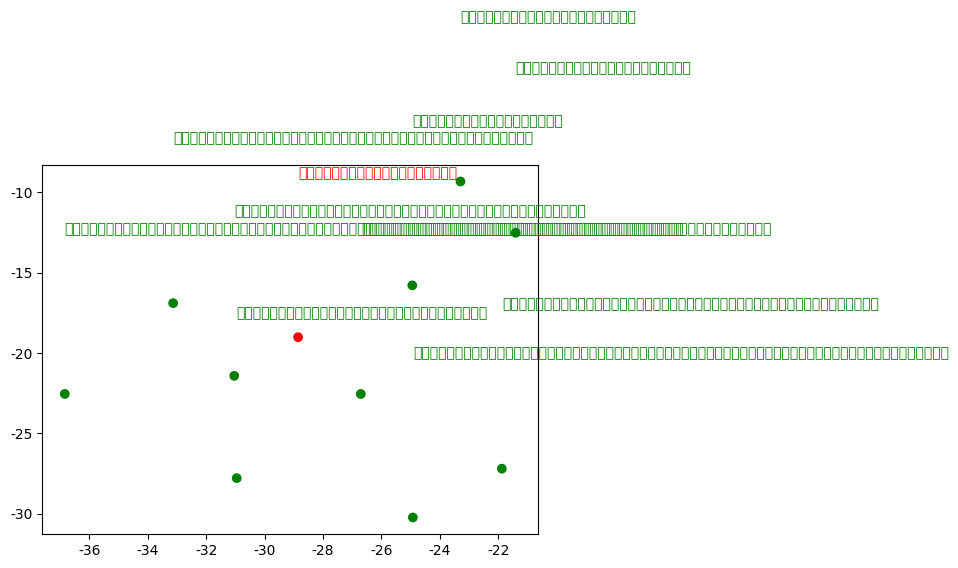

In [151]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 设置字体以支持中文显示
plt.rcParams['font.family'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 将查询句子的嵌入添加到句子嵌入数组的首位
all_embeddings = np.vstack([embedded_query, sentence_embeddings])

# 运行 TSNE 降维，固定随机种子以保持结果一致
# n_components (整数): 这个参数指定目标空间的维度。在这里设置为 2，意味着t-SNE将把数据降维到二维空间。
# perplexity (浮点数): 这个参数是t-SNE中非常重要的一个参数，可以看作是考虑周围邻居的数量，它反映了数据局部结构的复杂性。
tsne = TSNE(n_components=2, perplexity=5)
embeddings_2d = tsne.fit_transform(all_embeddings)

# 创建颜色列表，查询句子为红色，其余为绿色
color_list = ['red'] + ['green'] * len(sentence_embeddings)

# 绘制散点图
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color=color_list)

# 添加文本标签，包括查询句子
sentences_with_query = [query] + sentences  # 加入查询句子到句子列表首位
for i in range(len(embeddings_2d)):
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1] + 10,  # 小幅调整文本位置以防重叠
             sentences_with_query[i],
             color=color_list[i])

# 显示图表
plt.show()

&emsp;&emsp;从上图中能够非常明显的看出，在分布上红色显示的为Query，不同文本间距离的远近表示着文本间的关联度，关联越大，两个文本的显示距离就越近。对`早睡早起到底是不是保持身体健康的标准？`这个问题，在10个绿色字体的答案中，两个最相关的`早睡早起确实是保持身体健康的重要因素之一。它有助于同步我们的生物钟，并提高睡眠质量。`和`早睡早起可以帮助人们更好地适应自然光周期，从而优化褪黑激素的产生，这种激素是调节睡眠和觉醒的关键。`是距离最近的，同时从自然语义上，也是最能回答该问题的答案。如果这是一个RAG系统，那么被检索出来的内容就会是这两个问题。从而也印证了Embeding后的向量，是具有极强的语义的。

> 有一点需要说明：大家在自己执行时会出现多次执行结果不同的情况，这是正常的，这是由于 t-SNE  算法的特性导致的。它在初始化过程中有一定的随机性。这意味着每次运行算法时，即使是在相同的Embeding向量上，得到的低维表示也可能不同。

- 接入更多Embedding模型

&emsp;&emsp;除了`OpenAI`的`Embedding Models`可以使用`API`形式接入之外，LangChain也接入了其他提供API调用的平台，比如国内的`Baidu Qianfan`，`ZhipuAI`等，具体支持的平台可以在如下位置进行查看：https://python.langchain.com/docs/integrations/text_embedding/

<div align=center><img src="https://muyu20241105.oss-cn-beijing.aliyuncs.com/images/202507071221041.png" width=80%></div>

&emsp;&emsp;当然，不同平台提供的`Embedding Models`也均需要按照其定制的收费标准付费。如果想免费使用`Embedding Models`，另外的一种形式则是下载开源的`Embedding Models`至本地，通过本地服务接入，但这个过程，需要消耗本地服务器的硬件资源，即会占用一定的`GPU`显存。

&emsp;&emsp;接下来我们就介绍一下：如何在`LangChain`框架中接入开源的`Embedding Models`。

### 2. 开源Embedding Models接入

&emsp;&emsp;在`LangChain`框架中如果想使用开源`Embedding Models`，需要先将具体的`Embedding Models`的全部权重文件下载至本地后才能进行加载，这与本地化部署开源大模型是一样的，其在调用过程中也会消耗一定的`GPU`资源，而消耗的多少显存则取决于`Embedding Models`的参数量。

&emsp;&emsp;`LangChain`集成的开源`Embedding`模型托管平台主要有`Hugging Face`、`Ollama`、`Vllm`等，在使用上与`OpenAI Embedding Models`等`API`形式差异也并不大，唯一需要做的前置工作是：需要把离线的`Embedding Models`从指定的托管平台上下载至本地。我们以`BAAI/bge-base-zh-v1.5`模型为例，向大家介绍下载及使用方法，并通过`Ollama`平台进行部署，最后通过`LangChain`框架进行调用。

<div align=center><img src="https://muyu20241105.oss-cn-beijing.aliyuncs.com/images/202502251208767.png" width=80%></div>

&emsp;&emsp;`Ollama` 除了可以接入对话、推理类模型外，还可以接入 `Embedding` 模型。并且部署和使用方法基本与对话、推理类模型保持一致。官方下载地址：https://ollama.com/search?c=embedding ，可点击链接进行查看：

<div align=center><img src="https://muyu20241105.oss-cn-beijing.aliyuncs.com/images/202502251006679.png" width=80%></div>

&emsp;&emsp;关于如何选择`Embedding`模型，这个问题本质上不存在哪个`Embedding`最好的说法，同时也并没有比较通用且大家都认可的评测数据、流程等，往往还是需要结合自己的实际数据情况加上构建流程评测出来的效果，来进行综合评估。所以这里给大家推荐一个相对完善的`Embedidng`模型评估开源项目，同时也是一个`RAG`的解决方案：https://github.com/timescale/pgai?ref=timescale.ghost.io

<div align=center><img src="https://muyu20241105.oss-cn-beijing.aliyuncs.com/images/202502261900608.png" width=80%></div>

&emsp;&emsp;该开源项目针对`Ollama`支持的`Embedding`模型做了一些基础的评测，如下：

<style>
.center
{
  width: auto;
  display: table;
  margin-left: auto;
  margin-right: auto;
}
</style>

<p align="center"><font face="黑体" size=4>常规参数</font></p>
<div class="center">

| 模型名称               | 优势                                         | 劣势                                         |
|----------------------|--------------------------------------------|--------------------------------------------|
| **bge-m3**           | <font color="red">整体检索准确率最高</font>                         | 在不清楚和含糊不清的问题上表现较差，最低准确率 |
|                      | 在长问题上表现出色                         |                                            |
| **mxbai-embed-large**| 尺寸小               | 在简短和直接的问题上表现不如其他模型      |
|                      | 在上下文较重的问题上表现良好               |                                            |
|                      | 长问题表现良好                             |                                            |
| **nomic-embed-text** | 在简短和直接的问题上表现优异               | 整体表现排名最后                          |
|                      | 在长问题上也取得了较好性能                 |                                            |
</div>

&emsp;&emsp;文信息。**bge**（**BAAI General Embeddin可以说是最受欢迎备受关注的开源Embedding模型，由北京智源人工智能研究院（BAAI）推出，旨在在多样化的下游任务中提供通用而高效的语义表示。bge系列模型特别强调对中文和英文文本的双语支持，具备较强的跨语言检索能力，这一特性在实际场景中尤为重要，比如中英文混合的搜索、问答与推荐系&emsp;&emsp;统。

bge模型的设计理念是通过大规模对比学习（Contrastive Learning），让模型能够识别和区分不同语义表达之间的细微差别。它在训练阶段利用了丰富的语料库，涵盖新闻、百科、问答、社交媒体等多种领域，从而具备良好的通用性。用户在使用bge时，可以直接将句子或文档输入模型，获得稠密的向量表示，这些向量可以被用作向量检索、相似性匹配或特&emsp;&emsp;目前，bge系列已经推出了多个主流的Embedding模型，主要包括**bge-small、bge-base、bge-large**以及针对多语言和指令微调优化的变体，每个版本都在参数规模、性能和使用场景上有所侧重。

&emsp;&emsp;最小版本**bge-small**体积轻量，推理速度快，非常适合对资源有限或对延迟敏感的应用场景，例如在边缘设备或移动端部署。尽管模型规模较小，但在中英文检索任务中依然具备不错的鲁棒性，对于一些基础的语义匹配和快速召回需求，bge-small往往已经足够应对。

&emsp;&emsp;中等规模的**bge-base**则是bge系列中应用最为广泛的版本之一，它在准确率和推理效率之间做到了良好平衡。bge-base在多项公开基准上都取得了领先的性能，尤其在中文检索、问答对齐以及多轮对话场景下表现出较强的泛化能力。许多开发者将bge-base作为向量数据库（如FAISS、Milvus）的默认Embedding模型，用于构建高质量的语义检索系统。

&emsp;&emsp;性能最强的**bge-large**版本在模型容量和表达能力方面进一步提升，适合对精度要求极高的场景，比如法律、金融等领域的大规模语义搜索或复杂问答。bge-large在向量表示上更为细腻，可以捕捉文本间更微妙的语义差异，但同时需要更多的显存和算力资源。

&emsp;&emsp;除了这些通用版本，bge还提供了**bge-m3**等多语言模型和**bge-reranker**这样的重排序模型。bge-m3在多语种环境下具备出色的跨语言检索能力，支持中英文及其他语种的混合对比学习，非常适合构建国际化的检索服务。而bge-reranker则是一种专用于对召回结果进行精细排序的模型，它可以与Embedding模型搭配使用，将粗排后的候选文本再进行一轮打分，显著提升最终的检索相关性。风格的版本，也可以告诉我！


&emsp;&emsp;这里我们选择`bge-m3`模型进行下载使用。点击具体的模型，可以查看模型的详细信息，如模型的大小、支持的设备、支持的参数等。

<div align=center><img src="https://muyu20241105.oss-cn-beijing.aliyuncs.com/images/202502251046299.png" width=80%></div>

&emsp;&emsp;首先需要确定服务器上的`Ollama`服务处于运行状态，通过如下命令查看：

```bash
    systemctl status ollama.service
```

<div align=center><img src="https://muyu20241105.oss-cn-beijing.aliyuncs.com/images/202502251046128.png" width=80%></div>

&emsp;&emsp;如果服务未处于运行状态，则可以通过如下命令启动：

```bash
    ollama start
```



&emsp;&emsp;启动`Ollama`服务后，通过如下命令下载并启动`bge-m3`模型：

```bash
    ollama run bge-m3
```

<div align=center><img src="https://muyu20241105.oss-cn-beijing.aliyuncs.com/images/202502251100592.png" width=80%></div>

&emsp;&emsp;需要说明的是，最后一行`Error: "bge-m3" does not support generation`，表示`bge-m3`模型不支持在类似对话模型启动后可以在命令行进行问答，需要通过`Ollama`的 `REST API` 进行使用。


&emsp;&emsp;注意：如果是`Windows`操作系统，则只需要安装`Ollama` 程序，然后在命令行终端执行即可：

<div align=center><img src="https://muyu20241105.oss-cn-beijing.aliyuncs.com/images/202507071247857.png" width=80%></div>

> 也可以考虑直接使用ollama pull+模型名称的方式拉取模型。

&emsp;&emsp;成功启动后，`Ollama` 提供给`Embedding` 模型使用的 `REST API` 接口为：`/api/embed`。其可以支持单个输入和多个输入的请求。具体可用的参数如下所示：

<style>
.center
{
  width: auto;
  display: table;
  margin-left: auto;
  margin-right: auto;
}
</style>

<p align="center"><font face="黑体" size=4>常规参数</font></p>
<div class="center">

| 参数名       | 类型               | 描述                                                         |
|------------|------------------|------------------------------------------------------------|
| <font color="red">**model**</font>      | 字符串            | 用于生成嵌入的模型名称                                       |
| <font color="red">**input**</font>      | 字符串或字符串列表 | 要生成嵌入的文本或文本列表                                   |
| truncate    | 布尔值            | 是否截断每个输入的末尾以适应上下文长度。若为 false 且超出上下文长度则返回错误。默认值为 true |
| options    | 对象              | 额外的模型参数，例如温度等   |
| keep_alive | 字符串            | 控制模型在请求后保持加载到内存中的时间（默认：5分钟）       |
</div>

&emsp;&emsp;同样，只要了解了某个服务的`REST API` 接口以及其请求参数，就都可以通过`Python` 的`requests` 库进行调用。代码如下：

In [ ]:
import requests
import json

# 定义 API 端点
url = "http://localhost:11434/api/embed"    # 这里需要根据实际情况进行修改

# 单个输入的请求示例
single_input_payload = {
    "model": "bge-m3",   # 这里替换成具体的模型名称
    "input": "大家好，我是九天，欢迎大家参加公开课~"   # 这里替换成具体的输入文本
}

# 发送 POST 请求
response_single = requests.post(url, json=single_input_payload)

# 检查响应
if response_single.status_code == 200:
    print("Single Input Response:")
    response_data_single = response_single.json()
    print(json.dumps(response_data_single, indent=2))
else:
    print(f"Error: {response_single.status_code} - {response_single.text}")


Single Input Response:
{
  "model": "bge-m3",
  "embeddings": [
    [
      -0.046659067,
      -0.03086418,
      -0.038325727,
      -0.03306833,
      -0.02908756,
      -0.05512413,
      -0.0010946739,
      -0.039185088,
      -0.0063753207,
      0.00884719,
      -0.009470685,
      0.030594885,
      -0.036936574,
      0.014304041,
      -0.0030965253,
      0.03649467,
      0.0014680256,
      0.0019168206,
      0.025951149,
      0.016300414,
      -0.0072286227,
      0.031177294,
      0.0046711676,
      -0.032218136,
      0.06295734,
      0.03693704,
      -0.027663302,
      -0.011615811,
      0.016045673,
      -0.050792705,
      0.036317814,
      0.019383054,
      -0.03331296,
      -0.045823332,
      -0.014865519,
      -0.060301173,
      0.058876876,
      -0.020425046,
      -0.04720107,
      -0.019266821,
      0.04100967,
      0.017244264,
      -0.0045315386,
      -0.04426912,
      0.023222923,
      -0.05573663,
      -0.008494671,
      0.011372

&emsp;&emsp;可以提取出`response_single.json()` 中的 `embeddings` 字段，这个字段是一个列表，里面包含了若干个浮点数。而这些浮点数，就是`bge-m3` 模型的嵌入结果，用来表示输入文本`"大家好，我是九天，欢迎大家参加公开课~"`这句话的语义。

In [ ]:
# 提取嵌入结果
response_data_single["embeddings"]

[[-0.046659067,
  -0.03086418,
  -0.038325727,
  -0.03306833,
  -0.02908756,
  -0.05512413,
  -0.0010946739,
  -0.039185088,
  -0.0063753207,
  0.00884719,
  -0.009470685,
  0.030594885,
  -0.036936574,
  0.014304041,
  -0.0030965253,
  0.03649467,
  0.0014680256,
  0.0019168206,
  0.025951149,
  0.016300414,
  -0.0072286227,
  0.031177294,
  0.0046711676,
  -0.032218136,
  0.06295734,
  0.03693704,
  -0.027663302,
  -0.011615811,
  0.016045673,
  -0.050792705,
  0.036317814,
  0.019383054,
  -0.03331296,
  -0.045823332,
  -0.014865519,
  -0.060301173,
  0.058876876,
  -0.020425046,
  -0.04720107,
  -0.019266821,
  0.04100967,
  0.017244264,
  -0.0045315386,
  -0.04426912,
  0.023222923,
  -0.05573663,
  -0.008494671,
  0.01137218,
  -0.0017053627,
  -0.006873672,
  -0.00799992,
  -0.01605918,
  0.040367838,
  -0.0040091584,
  -0.008877462,
  0.020989623,
  0.027089478,
  0.0008631978,
  -0.048587214,
  -0.017943619,
  -0.058094405,
  0.04771232,
  0.002526571,
  -0.02046576,
  0.02783

&emsp;&emsp;具体用多少个浮点数来表示输入文本的语义，取决于具体的模型。比如我们使用的`bge-m3` 模型，其返回的嵌入结果就是一个包含`1024`个浮点数的列表。

In [ ]:
len(response_data_single["embeddings"][0])

1024

&emsp;&emsp;大家可以在`huggingface` 或者 `modelScope` 等平台上，找到`bge-m3` 模型的详细架构、评测信息及论文。我们这里不作为重点展开讲解。`bge-m3` 模型在`modelScope` 平台上的地址为：https://modelscope.cn/models/BAAI/bge-m3

<div align=center><img src="https://muyu20241105.oss-cn-beijing.aliyuncs.com/images/202502251128661.png" width=80%></div>

&emsp;&emsp; 所以大家可以简单理解为, 经过`bge-m3` 模型处理后的结果, 就是将输入的文本转换为一个包含`1024`个浮点数的列表，并且用这个列表来表示输入文本的语义。即 response_data_single["embeddings"][0] = "大家好，我是九天，欢迎大家参加公开课~"


&emsp;&emsp; 同时，`bge-m3` 模型还支持多个输入的请求，即可以一次性输入多个文本，然后返回每个文本的嵌入结果。代码如下：

In [ ]:
import requests
import json

# 定义 API 端点
url = "http://localhost:11434/api/embed"    # 这里需要根据实际情况进行修改


# 多个输入的请求示例
multiple_input_payload = {
    "model": "bge-m3",
    "input": ["天为什么是蓝色的？",
              "草为什么是绿色的？"]
}

# 发送 POST 请求
response_multiple = requests.post(url, json=multiple_input_payload)

# 检查响应
if response_multiple.status_code == 200:
    print("\nMultiple Input Response:")
    response_data_multiple = response_multiple.json()
    print(json.dumps(response_data_multiple, indent=2))

    # 提取嵌入结果
    multiple_embeddings = response_data_multiple.get("embeddings", [])
else:
    print(f"Error: {response_multiple.status_code} - {response_multiple.text}")


Multiple Input Response:
{
  "model": "bge-m3",
  "embeddings": [
    [
      -0.04207635,
      0.0052753137,
      -0.037689693,
      -0.062225435,
      -0.030415105,
      -0.007835005,
      -0.043910522,
      0.0022439896,
      0.016321266,
      -0.01189869,
      -0.004619244,
      0.025634116,
      0.007863776,
      0.0061966227,
      0.018475268,
      -0.022252694,
      0.029493438,
      0.022546498,
      0.00040247286,
      0.019579906,
      -0.009821156,
      -0.038343757,
      -0.032574885,
      0.016091952,
      -0.006142269,
      0.0075541674,
      0.016633386,
      -0.017747514,
      -0.00029206014,
      0.0014801843,
      0.004169274,
      0.06163229,
      -0.029013896,
      -0.022353716,
      0.0003854214,
      -0.017606797,
      -0.0054742927,
      0.004829356,
      -0.040224206,
      -0.032854013,
      0.00966942,
      -0.039152823,
      0.017514894,
      -0.00050754816,
      0.02769058,
      -0.046246927,
      -0.011701116,
 

In [ ]:
print("Total embeddings:", len(multiple_embeddings))
print("First embedding:", len(multiple_embeddings[0]), multiple_embeddings[0])  # 表示天为什么是蓝色的？
print("Second embedding:", len(multiple_embeddings[1]), multiple_embeddings[1])  # 表示草为什么是绿色的？

Total embeddings: 2
First embedding: 1024 [-0.04207635, 0.0052753137, -0.037689693, -0.062225435, -0.030415105, -0.007835005, -0.043910522, 0.0022439896, 0.016321266, -0.01189869, -0.004619244, 0.025634116, 0.007863776, 0.0061966227, 0.018475268, -0.022252694, 0.029493438, 0.022546498, 0.00040247286, 0.019579906, -0.009821156, -0.038343757, -0.032574885, 0.016091952, -0.006142269, 0.0075541674, 0.016633386, -0.017747514, -0.00029206014, 0.0014801843, 0.004169274, 0.06163229, -0.029013896, -0.022353716, 0.0003854214, -0.017606797, -0.0054742927, 0.004829356, -0.040224206, -0.032854013, 0.00966942, -0.039152823, 0.017514894, -0.00050754816, 0.02769058, -0.046246927, -0.011701116, -0.032883402, -0.044740733, -0.048008934, 0.008517099, 0.0038645687, 0.08823752, -0.016359365, 0.011783315, -0.002995275, 0.027993893, -0.030887553, -0.043222964, -0.028803417, -0.014748299, -0.0021559906, -0.041486118, 0.008731692, -0.013645054, 0.089960545, 0.020394227, -0.004462064, -0.0201111, -0.0048628226,

&emsp;&emsp;`Ollama`启动的`Embedding REST API` 同样是兼容了`OpenAI` 的接口规范，因此也可以用如下方式进行调用：

In [ ]:
from openai import OpenAI
client = OpenAI(base_url="http://localhost:11434/v1")  # 需要根据自己的实际情况调整

response = client.embeddings.create(
  model="bge-m3",  # 这里替换成 bge-m3 模型
  input="大家好，我是九天，欢迎大家参加公开课~",
)

print(response)

CreateEmbeddingResponse(data=[Embedding(embedding=[-0.046659067, -0.03086418, -0.038325727, -0.03306833, -0.02908756, -0.05512413, -0.0010946739, -0.039185088, -0.0063753207, 0.00884719, -0.009470685, 0.030594885, -0.036936574, 0.014304041, -0.0030965253, 0.03649467, 0.0014680256, 0.0019168206, 0.025951149, 0.016300414, -0.0072286227, 0.031177294, 0.0046711676, -0.032218136, 0.06295734, 0.03693704, -0.027663302, -0.011615811, 0.016045673, -0.050792705, 0.036317814, 0.019383054, -0.03331296, -0.045823332, -0.014865519, -0.060301173, 0.058876876, -0.020425046, -0.04720107, -0.019266821, 0.04100967, 0.017244264, -0.0045315386, -0.04426912, 0.023222923, -0.05573663, -0.008494671, 0.01137218, -0.0017053627, -0.006873672, -0.00799992, -0.01605918, 0.040367838, -0.0040091584, -0.008877462, 0.020989623, 0.027089478, 0.0008631978, -0.048587214, -0.017943619, -0.058094405, 0.04771232, 0.002526571, -0.02046576, 0.027837481, 0.066276774, 0.00044096838, 0.0054441937, 0.01892457, -0.0070083467, 0.00

In [ ]:
print(response.data[0].embedding)

[-0.046659067, -0.03086418, -0.038325727, -0.03306833, -0.02908756, -0.05512413, -0.0010946739, -0.039185088, -0.0063753207, 0.00884719, -0.009470685, 0.030594885, -0.036936574, 0.014304041, -0.0030965253, 0.03649467, 0.0014680256, 0.0019168206, 0.025951149, 0.016300414, -0.0072286227, 0.031177294, 0.0046711676, -0.032218136, 0.06295734, 0.03693704, -0.027663302, -0.011615811, 0.016045673, -0.050792705, 0.036317814, 0.019383054, -0.03331296, -0.045823332, -0.014865519, -0.060301173, 0.058876876, -0.020425046, -0.04720107, -0.019266821, 0.04100967, 0.017244264, -0.0045315386, -0.04426912, 0.023222923, -0.05573663, -0.008494671, 0.01137218, -0.0017053627, -0.006873672, -0.00799992, -0.01605918, 0.040367838, -0.0040091584, -0.008877462, 0.020989623, 0.027089478, 0.0008631978, -0.048587214, -0.017943619, -0.058094405, 0.04771232, 0.002526571, -0.02046576, 0.027837481, 0.066276774, 0.00044096838, 0.0054441937, 0.01892457, -0.0070083467, 0.0071977833, -0.004573465, 0.012675319, 0.0018473077,

&emsp;&emsp;`Ollama` 兼容的 `OpenAI` 接口，其返回的结果与 `Ollama` 的 `REST API` 接口返回的结果是一样的。同时`input` 参数也同样支持单个输入和多个输入。如果需要嵌入多个文本，则需要将`input` 参数设置为列表，如下所示：

In [ ]:
from openai import OpenAI
client = OpenAI(base_url="http://localhost:11434/v1")

batch_input = ["天为什么是蓝色的？", "草为什么是绿色的？"]


response = client.embeddings.create(
  model="bge-m3",
  input=batch_input
)

print(response)

CreateEmbeddingResponse(data=[Embedding(embedding=[-0.04207635, 0.0052753137, -0.037689693, -0.062225435, -0.030415105, -0.007835005, -0.043910522, 0.0022439896, 0.016321266, -0.01189869, -0.004619244, 0.025634116, 0.007863776, 0.0061966227, 0.018475268, -0.022252694, 0.029493438, 0.022546498, 0.00040247286, 0.019579906, -0.009821156, -0.038343757, -0.032574885, 0.016091952, -0.006142269, 0.0075541674, 0.016633386, -0.017747514, -0.00029206014, 0.0014801843, 0.004169274, 0.06163229, -0.029013896, -0.022353716, 0.0003854214, -0.017606797, -0.0054742927, 0.004829356, -0.040224206, -0.032854013, 0.00966942, -0.039152823, 0.017514894, -0.00050754816, 0.02769058, -0.046246927, -0.011701116, -0.032883402, -0.044740733, -0.048008934, 0.008517099, 0.0038645687, 0.08823752, -0.016359365, 0.011783315, -0.002995275, 0.027993893, -0.030887553, -0.043222964, -0.028803417, -0.014748299, -0.0021559906, -0.041486118, 0.008731692, -0.013645054, 0.089960545, 0.020394227, -0.004462064, -0.0201111, -0.004

In [ ]:
print(len(response.data))
print(len(response.data[0].embedding))
print(len(response.data[1].embedding))

2
1024
1024


&emsp;&emsp;至此，`Ollama`启动并使用`Embedding`模型的相关使用方法就已经介绍完毕，并没有很复杂的流程，同时其参数也比较容易理解。

&emsp;&emsp;接下来我们来看一下如果接入LangChain，应该如何加载到这个使用`Ollma`启动的本地的`bge-m3 Embedding`模型。首先，`LangChain` 封装了用于加载托管在`Ollama`平台的开源`Embedding`模型，命名为`OllamaEmbeddings`， 其官方文档位置如下：https://python.langchain.com/docs/integrations/text_embedding/ollama/

<div align=center><img src="https://muyu20241105.oss-cn-beijing.aliyuncs.com/images/202507071252218.png" width=80%></div>

&emsp;&emsp;使用前，还是需要导入相关的模块。

In [ ]:
# ! pip install -qU langchain-ollama

In [ ]:
from langchain_ollama import OllamaEmbeddings

&emsp;&emsp;这里使用`HuggingFaceEmbeddings`类，同时通过`base_url`参数指定`Ollama`的`REST API`地址，通过`model`参数指定`Embedding`模型名称。因为是本地模型，所以不需要`API_KEY`。

In [ ]:
embeddings = OllamaEmbeddings(
    base_url="http://localhost:11434",
    model="bge-m3",
)

&emsp;&emsp;进行测试：

In [ ]:
query = "早睡早起到底是不是保持身体健康的标准？"

sentences = ["早睡早起确实是保持身体健康的重要因素之一。它有助于同步我们的生物钟，并提高睡眠质量。",
             "早睡早起可以帮助人们更好地适应自然光周期，从而优化褪黑激素的产生，这种激素是调节睡眠和觉醒的关键。",
             "关于提高工作效率，确保在日常饮食中包含充足的蛋白质、复合碳水化合物和健康脂肪非常关键。",
             "投资可再生能源项目和推广电动汽车可以显著减少温室气体排放，从而缓解气候变化带来的负面影响。",
             "多发性硬化症是一种影响中枢神经系统的自身免疫疾病，导致神经传导受损。虽然与阿尔茨海默症类似，多发性硬化症的主要症状包括疲劳、视觉障碍和肌肉控制问题。",
             "今天的天气太好了，可以早点起床去爬山",
             "如果下班特别晚的话，我建议你还是打车回家吧",
             "提升学术研究质量需侧重于多学科融合和国际合作。研究机构应该鼓励学者之间的交流，通过共享数据和研究方法，来推动科学发现和技术创新。",
             "如果你认为我说的没用，那你大可以不必理会。",
             "衡量一个人是否成功的标准在于他到底能不能让身边的人都变的优秀"
]

&emsp;&emsp;接下来就可以使用`embed_documents`方法来进行文档对象的Embedding向量化。

In [ ]:
sentence_embeddings = embeddings.embed_documents(sentences)

&emsp;&emsp;并使用`embed_query`方法来进行单条文本`query`的向量化。

In [ ]:
query = "早睡早起到底是不是保持身体健康的标准？"

# QA场景：嵌入一段文本，以便与其他Embedding Vector进行比较。
embedded_query = embeddings.embed_query(query)

In [ ]:
len(embedded_query)

1024

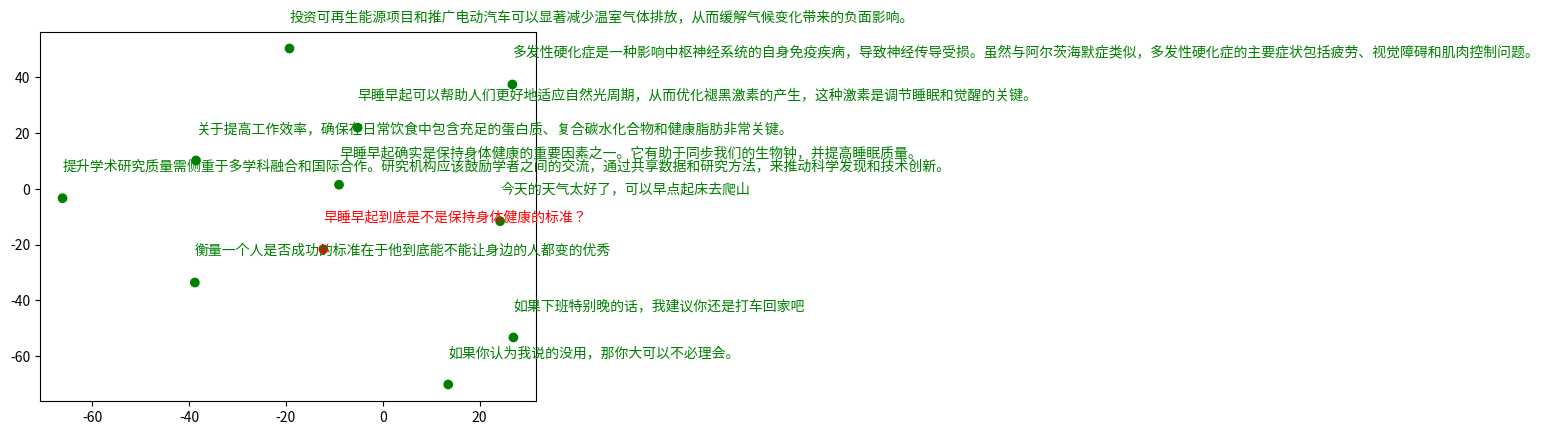

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 设置字体以支持中文显示
plt.rcParams['font.family'] = 'Noto Sans CJK JP'
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 将查询句子的嵌入添加到句子嵌入数组的首位
all_embeddings = np.vstack([embedded_query, sentence_embeddings])

# 运行 TSNE 降维，固定随机种子以保持结果一致
# n_components (整数): 这个参数指定目标空间的维度。在这里设置为 2，意味着t-SNE将把数据降维到二维空间。
# perplexity (浮点数): 这个参数是t-SNE中非常重要的一个参数，可以看作是考虑周围邻居的数量，它反映了数据局部结构的复杂性。
tsne = TSNE(n_components=2, perplexity=5)
embeddings_2d = tsne.fit_transform(all_embeddings)

# 创建颜色列表，查询句子为红色，其余为绿色
color_list = ['red'] + ['green'] * len(sentence_embeddings)

# 绘制散点图
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color=color_list)

# 添加文本标签，包括查询句子
sentences_with_query = [query] + sentences  # 加入查询句子到句子列表首位
for i in range(len(embeddings_2d)):
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1] + 10,  # 小幅调整文本位置以防重叠
             sentences_with_query[i],
             color=color_list[i])


# 显示图表
plt.show()

&emsp;&emsp;从这个结果看，相较于`OpenAI`的`Embedding Models`生成的向量表示，还是有一些差距，至少从上述可视化图表中发现相似的文本并没有很好的分布在相邻的簇中。但其实这并不绝对，因为`TSNE`降维本身就是一个不稳定的过程，可能在原始的高维向量表示中并不会出现这样的问题。所以大家仅把上述可视化结果作为一个直观参考即可，在开源的`Embedding` 模型中，`bge-m3`生成的词向量还是比较优秀的。当然，开源模型的性能相较于在线模型，尤其是跟`OpenAI`的模型相比，存在很大的差距这也是实际存在的。

- Embedding模型评测榜单

&emsp;&emsp;那么如何根据自己的数据情况选择最合适的`Embedding` 模型呢，这里有一个基本的衡量方法。首先，在`Huggging Face` 的 `mteb/leaderboard` 有一个较为优质的评测榜单：https://huggingface.co/spaces/mteb/leaderboard ，该榜单中包含了很多`Embedding` 模型，并且每个模型都给出了在不同任务上的得分。

<div align=center><img src="https://muyu20241105.oss-cn-beijing.aliyuncs.com/images/202507071303029.png" width=80%></div>

&emsp;&emsp;在选择`Embedding`模型时，大家可以考虑以下四个关键因素来确保能选取到最适合当前需求的模型：

1. **文本长度和块大小（Chunk Size 和 Sequence Length）**：模型选择应基于文本块的大小和序列长度，这通常取决于预期回答的长度。选择能够有效处理特定文本长度的模型。

2. **Embedding维度**：维度大小并非总是越大越好。如果文本语义丰富，较高的维度可能更有利于捕捉复杂信息。然而，对于语义较简单和直接的文本，较小的维度可能更为有效。

3. **模型大小和硬件资源**：根据可用的硬件资源（如显存大小），选择合适的模型。如果硬件资源充足，可以选择较大的模型，一般来说模型越大，性能越好，但是这并不绝对。

4. **实际测试和验证**：使用一个简单的`Demo`来测试模型的实际效果。如果初步的可视化测试结果不理想，那么有可能是不适合的。但这并不绝对，比如上面的例子，因为是降维之后的可视化，所以有可能在高维下，其表现是很好的，所以要综合衡量。

### 4. 计算向量之间的相似度

&emsp;&emsp;在上面的例子中，我们用可视化降维来衡量不同文本之间的相似度是不精准且随机的，所以向量之间的相似度往往是通过一些具体的算法来计算的，向量和标量最大的区别在于向量是有方向的，而标量没有方向，只有大小。那么对于向量，一些常用的计算方法比如：

- 点积（内积）: 两个向量的点积是一种衡量它们在同一方向上投影的大小的方法。如果两个向量是单位向量（长度为1），它们的点积等于它们之间夹角的余弦值。因此，点积经常被用来计算两个向量的相似度。

- 余弦相似度: 这是一种通过测量两个向量之间的角度来确定它们相似度的方法。余弦相似度是两个向量点积和它们各自长度乘积的商。这个值的范围从-1到1，其中1表示完全相同的方向，-1表示完全相反，0表示正交。

- 欧氏距离: 这种方法测量的是两个向量在n维空间中的实际距离。虽然它通常用于计算不相似度（即距离越大，不相似度越高），但可以通过某些转换（如取反数或用最大距离归一化）将其用于相似度计算。

&emsp;&emsp;像我们最常用的余弦相似度，其代码实现也非常简单，如下所示：

In [152]:
import numpy as np

def cosine_similarity(A, B):
    # 使用numpy的dot函数计算两个数组的点积
    # 点积是向量A和向量B在相同维度上对应元素乘积的和
    dot_product = np.dot(A, B)

    # 计算向量A的欧几里得范数（长度）
    # linalg.norm默认计算2-范数，即向量的长度
    norm_A = np.linalg.norm(A)

    # 计算向量B的欧几里得范数（长度）
    norm_B = np.linalg.norm(B)

    # 计算余弦相似度
    # 余弦相似度定义为向量点积与向量范数乘积的比值
    # 这个比值表示了两个向量在n维空间中的夹角的余弦值
    return dot_product / (norm_A * norm_B)

&emsp;&emsp;接下来，定义一个`get_embedding`函数，使用`OpenAI`的`Embedding Models`来对文本生成向量。

In [153]:
from openai import OpenAI

client = OpenAI(api_key=OPENAI_EMBEDDING_API_KEY, base_url="https://dashscope.aliyuncs.com/compatible-mode/v1")

def get_embedding(text, model="text-embedding-v4"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

In [154]:
embedding1 = get_embedding("我正在学习大模型技术应用实战课")
embedding2 = get_embedding("如果你想找到大模型岗位的工作，一定要来学习大模型技术实战课")
embedding3 = get_embedding("我喜欢打篮球")

In [155]:
len(embedding1)

1024

&emsp;&emsp;然后用定义好的`cosine_similarity`函数，使用余弦相似度计算两个文本间的相似度。

In [156]:
cosine_similarity(embedding1, embedding2)

np.float64(0.8098873940572412)

In [157]:
cosine_similarity(embedding1, embedding3)

np.float64(0.2001229687970153)

In [158]:
embedding4 = get_embedding("我也在学习大模型技术应用实战课")

In [159]:
cosine_similarity(embedding1, embedding4)

np.float64(0.9588136869334949)

&emsp;&emsp;从上面这个测试结果能看出，当两段文本的语义越相近，通过余弦相似度计算出来的分数就越高。这也是衡量文本相似度最为常用的方法。当然，我们也可以把这个流程应用在`LangChain`的数据处理流中，如下：

&emsp;&emsp;首先，我们通过`Document Loaders`读取到一个外部的.txt文件。

In [160]:
from langchain.document_loaders import TextLoader

docs = TextLoader('./Multitheme_Test_Document_Chinese.txt', encoding="utf-8").load()

In [161]:
print(docs[0].page_content)


科技创新：
随着技术的快速发展，人工智能和机器学习已经成为当下最热门的话题之一。从智能助手到自动驾驶汽车，AI的应用正在改变我们的生活方式。同时，关于数据隐私和机器伦理的讨论也日益增加，呼吁制定更明确的规范和法律。

环境保护：
全球气候变化对自然和人类社会构成了巨大的挑战。在这种情况下，推广绿色能源、减少塑料使用并保护生态多样性显得尤为重要。多国政府和非政府组织正在努力寻找解决方案，以减轻环境退化的影响。

经济趋势：
在全球化的大背景下，中国经济持续其增长势头，同时全球经济格局也在经历重大的转变。数字货币和区块链技术被视为金融领域的革命性创新，预计将对世界经济产生深远的影响。

文化艺术：
中国传统文化如书法和京剧在现代社会中依然占有重要地位。同时，现代艺术家也在尝试将传统艺术形式与现代技术结合，创造出新的艺术表现形式。艺术节和展览为这些创新提供了展示的平台。

健康生活：
现代生活节奏加快，健康问题也越来越受到人们的关注。健康饮食、规律运动是维持健康的重要因素。此外，心理健康和压力管理也开始被更多人重视，相关的研究和讨论日益增多。

旅游探险：
旅游已成为现代人生活的一部分，不仅是放松心情，更是一种文化和自我探索的方式。从遥远的北极圈到热带雨林，人们越来越愿意探索未知的领域，体验不同的文化和自然环境。



&emsp;&emsp;这份文档中的文本内容覆盖了多个主题，用来增强测试的复杂性。接下来，使用`Text Splitters`中的`RecursiveCharacterTextSplitter`进行文本分块：

In [162]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=300, chunk_overlap=0)

In [163]:
docs = text_splitter.split_documents(docs)

In [164]:
len(docs)

6

In [165]:
docs[0].page_content

'科技创新：\n随着技术的快速发展，人工智能和机器学习已经成为当下最热门的话题之一。从智能助手到自动驾驶汽车，AI的应用正在改变我们的生活方式。同时，关于数据隐私和机器伦理的讨论也日益增加，呼吁制定更明确的规范和法律。'

In [166]:
docs[1].page_content

'环境保护：\n全球气候变化对自然和人类社会构成了巨大的挑战。在这种情况下，推广绿色能源、减少塑料使用并保护生态多样性显得尤为重要。多国政府和非政府组织正在努力寻找解决方案，以减轻环境退化的影响。'

In [167]:
for index, doc in enumerate(docs):
    print(f"Chunk {index + 1}: {doc.page_content}\n")

Chunk 1: 科技创新：
随着技术的快速发展，人工智能和机器学习已经成为当下最热门的话题之一。从智能助手到自动驾驶汽车，AI的应用正在改变我们的生活方式。同时，关于数据隐私和机器伦理的讨论也日益增加，呼吁制定更明确的规范和法律。

Chunk 2: 环境保护：
全球气候变化对自然和人类社会构成了巨大的挑战。在这种情况下，推广绿色能源、减少塑料使用并保护生态多样性显得尤为重要。多国政府和非政府组织正在努力寻找解决方案，以减轻环境退化的影响。

Chunk 3: 经济趋势：
在全球化的大背景下，中国经济持续其增长势头，同时全球经济格局也在经历重大的转变。数字货币和区块链技术被视为金融领域的革命性创新，预计将对世界经济产生深远的影响。

Chunk 4: 文化艺术：
中国传统文化如书法和京剧在现代社会中依然占有重要地位。同时，现代艺术家也在尝试将传统艺术形式与现代技术结合，创造出新的艺术表现形式。艺术节和展览为这些创新提供了展示的平台。

Chunk 5: 健康生活：
现代生活节奏加快，健康问题也越来越受到人们的关注。健康饮食、规律运动是维持健康的重要因素。此外，心理健康和压力管理也开始被更多人重视，相关的研究和讨论日益增多。

Chunk 6: 旅游探险：
旅游已成为现代人生活的一部分，不仅是放松心情，更是一种文化和自我探索的方式。从遥远的北极圈到热带雨林，人们越来越愿意探索未知的领域，体验不同的文化和自然环境。



&emsp;&emsp;如上所示，我们把每一个主题切分为一个单独的`Chunk`，一共生成了6个`Chunk`。接下来，通过`OpenAI` 的`Embedding Models`获取每个`Chunk`的向量表示：

In [168]:
from openai import OpenAI
client = OpenAI(api_key=OPENAI_EMBEDDING_API_KEY, base_url="https://dashscope.aliyuncs.com/compatible-mode/v1")

def get_embedding(text, model="text-embedding-v4"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

In [169]:
embeddings = [get_embedding(doc.page_content) for doc in docs]

In [170]:
embeddings

[[-0.06189081072807312,
  -0.0013403547927737236,
  0.04220100864768028,
  -0.02846917323768139,
  -0.0028776826802641153,
  0.06399185955524445,
  -0.026653269305825233,
  0.0937066525220871,
  -0.02249619923532009,
  0.09430695325136185,
  0.00459603825584054,
  -0.02276633493602276,
  0.060119930654764175,
  -0.008359161205589771,
  -0.07767867296934128,
  -0.006678324658423662,
  -0.006036755628883839,
  -0.008486725389957428,
  0.004926202353090048,
  -0.023441670462489128,
  0.002136688679456711,
  0.010175066068768501,
  0.10018987953662872,
  0.062311023473739624,
  -0.01830911450088024,
  0.02225608006119728,
  0.06849409639835358,
  0.04493236914277077,
  -0.0201400276273489,
  -0.0006223410600796342,
  -0.002149820327758789,
  -0.000365338142728433,
  0.05291634425520897,
  0.026938410475850105,
  -0.025812851265072823,
  0.03529757261276245,
  -0.01230612676590681,
  0.021805856376886368,
  0.008629295974969864,
  -0.029819846153259277,
  0.030570220202207565,
  -0.01059527

In [171]:
len(embeddings)

6

In [172]:
len(embeddings[0])

1024

&emsp;&emsp;然后，通过如下代码获取到query的向量表示：

In [174]:
response = client.embeddings.create(
    input="现在科技创新方面有什么进展？",
    model="text-embedding-v4"
)

query_embedding = response.data[0].embedding

In [175]:
query_embedding

[-0.014730493538081646,
 -0.01981430873274803,
 0.014883187599480152,
 -0.0209101140499115,
 -0.011685592122375965,
 0.1043350026011467,
 -0.03919748216867447,
 0.07976023107767105,
 -0.024610701948404312,
 0.07983208447694778,
 -0.03341307118535042,
 -0.0015718514332547784,
 0.07925723493099213,
 -0.006233513355255127,
 -0.1110176220536232,
 -0.023640645667910576,
 -0.01437121257185936,
 -0.06147286295890808,
 -0.004827829077839851,
 -0.031059782952070236,
 -0.021359214559197426,
 0.02967655472457409,
 0.04821541905403137,
 0.08464644104242325,
 -0.017155636101961136,
 0.03655677288770676,
 0.0667542815208435,
 0.06671835482120514,
 -0.022472983226180077,
 -0.010571823455393314,
 0.015601747669279575,
 -0.002946098567917943,
 0.016455039381980896,
 -0.006044891197234392,
 -0.02518554963171482,
 0.03341307118535042,
 -0.04993996396660805,
 -0.0031684034038335085,
 0.012251459062099457,
 -0.04067053273320198,
 -0.02640710398554802,
 -0.0025823272299021482,
 0.01605983078479767,
 0.01990

&emsp;&emsp;在有了原始文档和`query`的向量表示后，我们通过余弦相似度去匹配哪一个`Chunk`中的内容，与输入的`query`是最相近的。

In [176]:
# 计算与查询最相近的文档块
similarities = [cosine_similarity(query_embedding, emb) for emb in embeddings]
max_index = np.argmax(similarities)  # 找到最高相似性的索引

# 打印最相似的文档块
print(f"The most similar chunk is Chunk {max_index + 1} with similarity {similarities[max_index]}:")
print(docs[max_index].page_content)

The most similar chunk is Chunk 1 with similarity 0.7414871210926252:
科技创新：
随着技术的快速发展，人工智能和机器学习已经成为当下最热门的话题之一。从智能助手到自动驾驶汽车，AI的应用正在改变我们的生活方式。同时，关于数据隐私和机器伦理的讨论也日益增加，呼吁制定更明确的规范和法律。


&emsp;&emsp;从输出上看，当`query`为`现在科技创新方面有什么进展？`,涉及到原始文档科技创新这一主题时，检索出来的最匹配内容就是存储着科技创新内容的这一个`chunk`。同样，我们可以继续进行测试，此次提问的`query`涉及经济问题：

In [177]:
response = client.embeddings.create(
    input="现在的经济趋势怎么样？",
    model="text-embedding-v4"
)

query_embedding = response.data[0].embedding

In [178]:
# 计算与查询最相近的文档块
similarities = [cosine_similarity(query_embedding, emb) for emb in embeddings]
max_index = np.argmax(similarities)  # 找到最高相似性的索引

# 打印最相似的文档块
print(f"The most similar chunk is Chunk {max_index + 1} with similarity {similarities[max_index]}:")
print(docs[max_index].page_content)

The most similar chunk is Chunk 3 with similarity 0.6723893851140815:
经济趋势：
在全球化的大背景下，中国经济持续其增长势头，同时全球经济格局也在经历重大的转变。数字货币和区块链技术被视为金融领域的革命性创新，预计将对世界经济产生深远的影响。


In [179]:
# 打印最相似的文档块以及其他所有文档块的相似度
print(f"The most similar chunk is Chunk {max_index + 1} with similarity {similarities[max_index]}:")
print(docs[max_index].page_content)

# 打印其他每一个的相似度
print("\nSimilarities of other chunks:")
for index, similarity in enumerate(similarities):
    if index != max_index:
        print(f"Chunk {index + 1} similarity: {similarity}")

The most similar chunk is Chunk 3 with similarity 0.6723893851140815:
经济趋势：
在全球化的大背景下，中国经济持续其增长势头，同时全球经济格局也在经历重大的转变。数字货币和区块链技术被视为金融领域的革命性创新，预计将对世界经济产生深远的影响。

Similarities of other chunks:
Chunk 1 similarity: 0.5472420655459721
Chunk 2 similarity: 0.39501882445386777
Chunk 4 similarity: 0.4572727508300381
Chunk 5 similarity: 0.5073704048881916
Chunk 6 similarity: 0.39395119311268467


&emsp;&emsp;对于经济问题，也能够很好的检索出原始文档中存储经济相关内容的`chunk`，这样的流程从本质上就是`RAG`检索的过程，只不过，一个应用级的`RAG`系统仅通过这样的简单设计肯定是不行的，首先，知识库存储的内容不可能这么少，`chunks`也不可能只有我们示例中的6个，那么当一个用户的`query`进入到这个`RAG`系统，`query`作为一个向量，要去偌大的知识库中（可能有几万、上千万个`chunks`）中找到与其最接近、内容最相关的问题，这就变成了一个搜索问题。

&emsp;&emsp;如果每个都去一一进行比较，这肯定是不现实的，它的时间复杂度会非常高，那有效的解决办法就是向量数据库，所以向量数据库，解决的核心问题是：如何以一种高效的搜索策略快速的返回检索结果。

&emsp;&emsp;接下来，我们就详细探讨一下向量数据库的应用方法和使用技巧。

### 5. 向量数据库详解

#### 5.1 向量数据库功能特性介绍

&emsp;&emsp;向量数据库，其解决的就是一个问题：更高效的实现搜索（`Search`）过程。传统数据库是先存储数据表，然后用查询语句（`SQL`）进行数据搜索，本质还是基于文本的精确匹配，这种方法对于关键字的搜索非常合适，但对于语义的搜索就非常弱。那么把传统数据库的索引思想引用到向量数据库中，同样是做搜索，在向量数据库的应用场景中就变成了：给定一个查询向量，然后在众多向量中找到最为相似的一些向量返回。这就不再是精确匹配，而是具有一定的模糊性，这就是所谓的最近邻（`Nearest Neighbors`）问题，而能实现这一点的则称之为【最近邻（搜索）算法】。

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404181144131.png" width=80%></div>

&emsp;&emsp;一种最容易想到的方法是暴力搜索，也就是我们在计算向量之间的相似度部分实现的那种计算形式，依次比较所有向量和查询向量的相似度，挑选出相似度最高的几个。而比较两个向量相似度的具体方法有很多，比如通过余弦相似度去计算两个向量的夹角，夹角越小表明两个文件之间越相似，或者直接计算两个向量的欧氏距离，距离越近越相似。而我们也提到了，实际应用中的向量规模往往都不会很小，这种毫无技术含量的暴力搜索会产生极高的搜索时间，在时效上很难保证的，所以必须找出一些方法来优化搜索的过程，那一个大致的思路就是：如果我们可以做到先为查询向量划分一个大致的范围后，再进入搜索，那么哪怕在这个范围内进行暴力搜索，其效率也会有一个质的提升。在机器学习领域呢，K-Means等聚类算法就能够做到这一点，那通过某种聚类算法分簇后，检索时其向量数据库的存储状态就会变成这样：

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404181321996.png" width=80%></div>

&emsp;&emsp;通过某种聚类算法先进行一轮训练，把相似向量划分到一个个不同的簇中，在实际执行搜索的时候，只需要找到和聚类向量中心点最近的那个向量，然后在这个簇中的执行搜索过程即可。但也会出现一些问题，比如下面这种情况：红色的点是查询向量落到的位置，它距离蓝色簇质心的距离最近，所以按照规则，它会去蓝色的簇中搜索向量，但实际上，与它最相近的向量是在黄色的簇中的红色点。

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404181328672.png" width=80%></div>

&emsp;&emsp;这个时候我们就可以通过划分多个簇来尽可能的减少这种遗漏的情况，但需要说明的是，一旦提高搜索质量通常会降低处理速度，这两者之间往往存在难以调和的矛盾。在实际应用中，几乎所有的算法都是在这两个指标之间寻求平衡。因此，除了暴力搜索之外，任何算法得到的都是一些近似的结果。这类算法也被称为“近似最近邻”（Approximate Nearest Neighbors，简称ANN）。

&emsp;&emsp;那除了聚类这种形式以外，减少搜索范围的方法还有很多，比如非常流行的哈希算法。哈希算法简单理解就是任何数据经过哈希函数计算后，都会输出一个固定的哈希值，那就会存在一个问题：将无限可能的输入映射到有限的输出范围内，就一定会出现不同的输入数据产生相同的哈希值的这种情况，这种现象被称为“碰撞”。一个理想的哈希算法是尽可能的减少这种碰撞，但向量数据库的哈希函数设计却反其道而行，它会倾向于增大碰撞发生的可能性，因为当哈希值一样，那它就会认为这两个向量是相似的，然后把这些向量划分到一起，在哈希算法下就不叫簇了，而叫做桶：Bucket。

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404181402159.png" width=80%></div>

&emsp;&emsp;除了增加碰撞的概率外，在向量数据库中的哈希函数让越相似的向量，发生碰撞的概率越高，通过这样的策略就会使得相似向量被分到同一个Bucket中的概率越大。如此，在查询的时候，先通过哈希函数找到查询向量的哈希值，然后去对应的Bucket中查找，以此来减小搜索范围。我们把具有这种特性的哈希函数称之为：位置敏感哈希 Locality Sensitive Hashing。当然，还有一些能够减低内存开销的搜索算法，比如有损压缩的PQ算法，基于图搜索的HNSW等，我们在后续使用时如果遇到，再开展给大家做详细的介绍。

&emsp;&emsp;总的来说，不同的向量数据库，底层实现的只是这种不同的逻辑，但核心都会搭建类似这样的流程。而在应用层面上，其展现出来将文本转换成向量，然后将向量存储在数据库中，当用户输入问题时，将问题转换成向量，然后在数据库中搜索最相似的向量和上下文，最后将文本返回给用户。

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404171246990.png" width=80%></div>

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250711165242730.png" alt="image-20250711165242730" style="zoom:33%;" />

#### 5.2 主流词向量数据库介绍

&emsp;&emsp;目前市面有非常多的向量数据库，从整体上可以分为开源和闭源，当然闭源意味着我们需要付费使用，而对于开源的向量数据库来说，可以下载免费使用。通过官方的数据来看，最常用的向量数据库如下：

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404181437374.png" width=80%></div>

&emsp;&emsp;其中`Pinecone`为闭源的向量数据库，`Chroma`为`LangChain`官方主推的向量数据库，同时`Faiss`和`Qdrant` 也非常受人们欢迎，且这三款均为开源的向量数据库，而像`Postgres`、`Neo4j`和`Redis`等原本较为传统的数据库，为适应当前大模型技术的发展趋势也添加了向量功能。

&emsp;&emsp;在`LangChain`中，`VectorStore` 类是专门用于处理向量数据库的类，其提供了多种不同的向量数据库实现，https://python.langchain.com/docs/concepts/retrievers/

<div align=center><img src="https://muyu20241105.oss-cn-beijing.aliyuncs.com/images/202507071314244.png" width=80%></div>

&emsp;&emsp;本节内容，我们就以`Chroma` 为示例，尝试一下在`LangChain`中如何使用集成的向量数据库，`Faiss`与`Chroma`的使用方式基本保持一致，所以我们就不再重复的说明，大家可以根据官方文档，结合我们接下来对`Chroma`的实操自行尝试。https://python.langchain.com/docs/integrations/vectorstores/chroma/

<div align=center><img src="https://muyu20241105.oss-cn-beijing.aliyuncs.com/images/202507071316879.png" width=80%></div>

&emsp;&emsp;`Chroma` 是一家构建开源项目（也称为 `Chroma`）的公司，其官网：https://www.trychroma.com/

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404181451605.png" width=80%></div>

&emsp;&emsp;它支持用于搜索、过滤等的丰富功能，并能与多种平台和工具（如`LangChain`, `LlamaIndex`, `OpenAI`等）集成。`Chroma`的核心`API`包括四个命令，分别用于创建集合、添加文档、更新和删除，以及执行查询。`Chroma`向量数据库官方原生支持`Python`和`JavaScript`，也有其他语言的社区版本支持。所以可以直接通过`Python`或`JS`操作，具体的操作文档可查阅其官方文档：https://docs.trychroma.com/

> Collection 是一组具有相似属性的文档集合，相当于关系型数据库中的表。在向量数据库中，数据存储为 Document，一组文档构成一个 Collection，一个 Database 中可以包含多个 Collection。

#### 5.3 Chroma词向量数据库安装与使用

&emsp;&emsp;我们这里重点看一下在LangChain框架中Chroma的应用。在使用时，因为Chroma是作为第三方集成，所以需要安装依赖包，执行如下代码：

In [180]:
! pip install langchain-chroma --index-url https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.5 MB/s eta 0:00:00
 

&emsp;&emsp;这里我们使用`OpenAI`的`Embedding`模型。

&emsp;&emsp;然后我们加载一个本地的.txt文档，里面的内容就是关于Sora的一些介绍。

In [1]:
from langchain.document_loaders import TextLoader

raw_documents = TextLoader('./sora.txt', encoding="utf-8").load()

In [2]:
raw_documents

[Document(metadata={'source': './sora.txt'}, page_content='一、Sora是什么？为什么说Sora是人工智能划时代的突破?\n\n2024年2月16日凌晨，OpenAI在官网发布了最新的文生视频模型Sora。Sora不仅突破了现有文生视频模型10秒左右的连贯性局限，而且展示出了更精细的画质、多角度多镜头切换中保持一致性等能力。最重要的是，Sora较好地表现出了现实世界中的逻辑，比如在模型生成的两艘海盗船在咖啡杯内航行的视频中，咖啡的流动完全符合现实世界中的流体力学；比如一则宠物猫等待主人起床的视频中，宠物猫踩奶的动作、对主人鼻头的轻触都符合现实世界中动物的习性。\n\n尽管出于安全性和测试验证等原因，Sora尚未开放给公众使用，但通过观察OpenAI发布的demo，不难发现Sora已经初步具备了理解现实世界运行规律的能力，即“涌现”的能力被成功得从大语言模型复制到了文生视频模型中。假以时日，人类或将很难区分现实世界和由AI生成的虚拟世界。除了为视频制作、电影剪辑、游戏设计等工作提升效率外，一个完全由数据驱动的数字世界或许已经近在咫尺。英伟达人工智能研究院首席科学家JimFan称“这是视频生成领域的GPT-3时刻”。360董事长周鸿祎称“Sora意味着AGI（通用人工智能）实现将从10年缩短到1年”。\n\n二、Sora是如何实现的？\n\n尽管OpenAI在Sora的技术文档中并未公开所有模型细节，但我们可以通过其描述大致推测出，Sora的实现仍然依赖于OpenAI在大语言模型领域取得巨大成功的“大力出奇迹”思想，即通过大幅提升训练数据和参数规模实现视频精度和对现实世界物理关系的“涌现”。\n\n相比GPT模型，Sora的成功之处在于为图像视频等多模态数据找到了适合Transformer架构的表征方式，从而将ScalingLaw从语言模型复制到了图像视频模型。此外，Sora在训练时还借助了DALL·E3生成的高质量文本描述，在推理时借助了GPT对用户输入进行扩展，可谓“站在巨人肩膀上”更进一步。\n\n三、Sora对AI应用和算力需求带来哪些影响?\n\n对于应用而言，Sora生成的视频已经达到了大部分消费级场景的使用要求，将为短视频创作等创意产业带来繁荣。随着模型升级，预计也将对电影、游戏等行业的制作效率带来

&emsp;&emsp;接下来，通过文档切割器`RecursiveCharacterTextSplitter`,将上面完整的Docement对象切分为多个chunks。

In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [4]:
text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", ""], # 默认
    chunk_size=500, #块长度
    chunk_overlap=20, #重叠字符串长度
    add_start_index=True
)

In [5]:
documents = text_splitter.split_documents(raw_documents)

In [6]:
len(documents)

6

In [7]:
print(documents[0].page_content)

一、Sora是什么？为什么说Sora是人工智能划时代的突破?

2024年2月16日凌晨，OpenAI在官网发布了最新的文生视频模型Sora。Sora不仅突破了现有文生视频模型10秒左右的连贯性局限，而且展示出了更精细的画质、多角度多镜头切换中保持一致性等能力。最重要的是，Sora较好地表现出了现实世界中的逻辑，比如在模型生成的两艘海盗船在咖啡杯内航行的视频中，咖啡的流动完全符合现实世界中的流体力学；比如一则宠物猫等待主人起床的视频中，宠物猫踩奶的动作、对主人鼻头的轻触都符合现实世界中动物的习性。


In [9]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

In [ ]:
embeddings_model = OpenAIEmbeddings(
    api_key="sk-XXXXX(自己的API-KEY)",
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
    model='text-embedding-v4'
    )

然后即可按照如下方式将其存储到Chroma词向量数据库中：

In [12]:
db = Chroma.from_documents(documents, embeddings_model)

BadRequestError: Error code: 400 - {'error': {'code': 'InvalidParameter', 'param': None, 'message': '<400> InternalError.Algo.InvalidParameter: Value error, contents is neither str nor list of str.: input.contents', 'type': 'InvalidParameter'}, 'id': 'df1b5654-40b9-9f35-9a2e-1ace456d6435', 'request_id': 'df1b5654-40b9-9f35-9a2e-1ace456d6435'}

&emsp;&emsp;我们看如下源码：`from_documents` 函数是`Chroma`类定义一个方法，主要用于从一系列文档（documents）中创建一个向量存储（vectorstore）。这个函数的功能点涉及多个方面，具体参数如下：

```python
    def from_documents(
        cls: Type[Chroma], # 类型参数，指向 Chroma 类型，用于方法中创建向量存储的实例。
        documents: List[Document], # 文档列表，每个文档都包含一些可用于生成向量的内容。
        embedding: Optional[Embeddings] = None,  # 可选的Embedding函数，用于将文档内容转换成向量。如果未提供，则使用默认设置。
        ids: Optional[List[str]] = None,  # 可选的文档ID列表，用于标识每个文档。
        collection_name: str = _LANGCHAIN_DEFAULT_COLLECTION_NAME,  # 向量存储的名称，默认为 _LANGCHAIN_DEFAULT_COLLECTION_NAME。
        persist_directory: Optional[str] = None,    # 如果指定，向量存储将被持久化到此目录。如果未指定，数据将只在内存中临时存在。
        client_settings: Optional[chromadb.config.Settings] = None,   # 可选的 Chroma 客户端配置设置。
        client: Optional[chromadb.ClientAPI] = None,  # Add this line   # 可选的 chromadb.ClientAPI 实例，用于数据库交互。
        collection_metadata: Optional[Dict] = None,  # 可选的字典，包含有关集合的额外元数据。
        **kwargs: Any,
    ) -> Chroma:
        """Create a Chroma vectorstore from a list of documents.

        If a persist_directory is specified, the collection will be persisted there.
        Otherwise, the data will be ephemeral in-memory.

        Args:
            collection_name (str): Name of the collection to create.
            persist_directory (Optional[str]): Directory to persist the collection.
            ids (Optional[List[str]]): List of document IDs. Defaults to None.
            documents (List[Document]): List of documents to add to the vectorstore.
            embedding (Optional[Embeddings]): Embedding function. Defaults to None.
            client_settings (Optional[chromadb.config.Settings]): Chroma client settings
            collection_metadata (Optional[Dict]): Collection configurations.
                                                  Defaults to None.

        Returns:
            Chroma: Chroma vectorstore.
        """
        texts = [doc.page_content for doc in documents]
        metadatas = [doc.metadata for doc in documents]
        return cls.from_texts(
            texts=texts,
            embedding=embedding,
            metadatas=metadatas,
            ids=ids,
            collection_name=collection_name,
            persist_directory=persist_directory,
            client_settings=client_settings,
            client=client,
            collection_metadata=collection_metadata,
            **kwargs,
        )
```

此时这个db就是一个词向量数据库对象：

In [ ]:
db

但需要注意的是，此时db对象是保存在内存里，如果想要本地持久保存，则需要运行如下代码，增加persist_directory参数：

In [ ]:
db = Chroma.from_documents(documents,
                           embeddings_model,
                           persist_directory="./chroma_langchain_db")

In [ ]:
db

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250711170004497.png" alt="image-20250711170004497" style="zoom:50%;" />

接下来如果想要再次读取这个词向量数据，则可以直接使用如下代码进行读取：

In [ ]:
vector_store = Chroma(
    persist_directory="./chroma_langchain_db",
    embedding_function=embeddings_model
)

In [ ]:
vector_store

&emsp;&emsp;这个方法的设计能够方便地从结构化文档数据中生成和管理向量存储，同时提供了灵活的配置选项（如`Embedding Models`的选择、持久化的选项等），以适应不同的应用场景和需求。

- 相似度计算

而对于词向量对象，我们可以直接借助similarity_search进行相似度计算，并检索得到与之最相关的文档片段：

In [ ]:
query = "什么是Sora"
docs = db.similarity_search(query)
print(docs[0].page_content)

一、Sora是什么？为什么说Sora是人工智能划时代的突破?

2024年2月16日凌晨，OpenAI在官网发布了最新的文生视频模型Sora。Sora不仅突破了现有文生视频模型10秒左右的连贯性局限，而且展示出了更精细的画质、多角度多镜头切换中保持一致性等能力。最重要的是，Sora较好地表现出了现实世界中的逻辑，比如在模型生成的两艘海盗船在咖啡杯内航行的视频中，咖啡的流动完全符合现实世界中的流体力学；比如一则宠物猫等待主人起床的视频中，宠物猫踩奶的动作、对主人鼻头的轻触都符合现实世界中动物的习性。


```python
    def similarity_search(
            self,
            query: str,
            k: int = DEFAULT_K,
            filter: Optional[Dict[str, str]] = None,
            **kwargs: Any,
        ) -> List[Document]:
            """Run similarity search with Chroma.

            Args:
                query (str): Query text to search for.
                k (int): Number of results to return. Defaults to 4.
                filter (Optional[Dict[str, str]]): Filter by metadata. Defaults to None.

            Returns:
                List[Document]: List of documents most similar to the query text.
            """
            docs_and_scores = self.similarity_search_with_score(
                query, k, filter=filter, **kwargs
            )
            return [doc for doc, _ in docs_and_scores]
        
        
        
        def similarity_search_with_score(
                self,
                query: str,
                k: int = DEFAULT_K,
                filter: Optional[Dict[str, str]] = None,
                where_document: Optional[Dict[str, str]] = None,
                **kwargs: Any,
            ) -> List[Tuple[Document, float]]:
                """Run similarity search with Chroma with distance.

                Args:
                    query (str): Query text to search for.
                    k (int): Number of results to return. Defaults to 4.
                    filter (Optional[Dict[str, str]]): Filter by metadata. Defaults to None.

                Returns:
                    List[Tuple[Document, float]]: List of documents most similar to
                    the query text and cosine distance in float for each.
                    Lower score represents more similarity.
                """
                if self._embedding_function is None:
                    results = self.__query_collection(
                        query_texts=[query],
                        n_results=k,
                        where=filter,
                        where_document=where_document,
                        **kwargs,
                    )
                else:
                    query_embedding = self._embedding_function.embed_query(query)
                    results = self.__query_collection(
                        query_embeddings=[query_embedding],
                        n_results=k,
                        where=filter,
                        where_document=where_document,
                        **kwargs,
                    )

                return _results_to_docs_and_scores(results)
```

&emsp;&emsp;在这段代码中， `_embedding_function` 会将查询字符串（自然语言）转换成一个Vector向量，通过 `__query_collection` 处理具体的搜索逻辑，利用余弦相似度在数据库中查找最相似的k个文档向量，最后，通过 `_results_to_docs_and_scores` 函数，可以将搜索结果转换成具体的文档列表和它们与查询的相似度评分。这个评分通常反映了查询向量与文档向量之间的距离，距离越小表示相似度越高。

In [ ]:
print(documents[3].page_content)

对于算力而言，由于OpenAI并未公布模型架构的细节，很难推测训练Sora具体消耗了多少算力，但既然ScalingLaw，或者说“大力出奇迹”依然是当前AI模型实现“涌现”的黄金法则，就意味着对算力的需求仍然没有看到“拐点”。如果Sora的训练确实使用了合成数据，意味着可供训练的数据远未耗尽，人类对AI模型参数和训练数据的提升还远远没有达到瓶颈。甚至随着AI模型合成数据能力的增强，模型推理结果本身就可以作为训练的一部分，从而实现AI的自我迭代。此外，视频生成推理需要更大的VRAM或带宽，如果Sora开放使用后如期推动各类视频创作的繁荣，当前电信和数通网络的带宽都需要大幅升级。作为广义算力的一部分，网络设备的需求也将爆发式增长。

对于投资而言，Sora最大的意义在于证明了AI产业的创新浪潮还远未停歇。Sora的“前辈”ChatGPT发布以来，芯片龙头英伟达、博通股价分别上涨超300%、130%，软件应用龙头微软上涨超60%。Sora作为多模态大模型，向公众开放后预计对算力需求更大、对软件应用成长空间提升更显著，有望进一步提升相关产业投资价值。


In [ ]:
query = "Sora在训练时消耗了多少算力？"
docs = db.similarity_search(query)
print(docs[0].page_content)

对于算力而言，由于OpenAI并未公布模型架构的细节，很难推测训练Sora具体消耗了多少算力，但既然ScalingLaw，或者说“大力出奇迹”依然是当前AI模型实现“涌现”的黄金法则，就意味着对算力的需求仍然没有看到“拐点”。如果Sora的训练确实使用了合成数据，意味着可供训练的数据远未耗尽，人类对AI模型参数和训练数据的提升还远远没有达到瓶颈。甚至随着AI模型合成数据能力的增强，模型推理结果本身就可以作为训练的一部分，从而实现AI的自我迭代。此外，视频生成推理需要更大的VRAM或带宽，如果Sora开放使用后如期推动各类视频创作的繁荣，当前电信和数通网络的带宽都需要大幅升级。作为广义算力的一部分，网络设备的需求也将爆发式增长。

对于投资而言，Sora最大的意义在于证明了AI产业的创新浪潮还远未停歇。Sora的“前辈”ChatGPT发布以来，芯片龙头英伟达、博通股价分别上涨超300%、130%，软件应用龙头微软上涨超60%。Sora作为多模态大模型，向公众开放后预计对算力需求更大、对软件应用成长空间提升更显著，有望进一步提升相关产业投资价值。


&emsp;&emsp;除此之外，还可以使用`similarity_search_by_vector` 搜索与给定`Embedding`向量类似的文档，它接受`Embedding`向量作为参数而不是字符串。

```python
    def similarity_search_by_vector(
            self,
            embedding: List[float],
            k: int = DEFAULT_K,
            filter: Optional[Dict[str, str]] = None,
            where_document: Optional[Dict[str, str]] = None,
            **kwargs: Any,
        ) -> List[Document]:
            """Return docs most similar to embedding vector.
            Args:
                embedding (List[float]): Embedding to look up documents similar to.
                k (int): Number of Documents to return. Defaults to 4.
                filter (Optional[Dict[str, str]]): Filter by metadata. Defaults to None.
            Returns:
                List of Documents most similar to the query vector.
            """
            results = self.__query_collection(
                query_embeddings=embedding,
                n_results=k,
                where=filter,
                where_document=where_document,
                **kwargs,
            )
            return _results_to_docs(results)
```

&emsp;&emsp;所以在使用时，就需要先将Query也转化成Vector。

In [ ]:
query = "Sora在训练时消耗了多少算力？"

embedding_vector = embeddings_model.embed_query(query)
docs = db.similarity_search_by_vector(embedding_vector)
print(docs[0].page_content)

对于算力而言，由于OpenAI并未公布模型架构的细节，很难推测训练Sora具体消耗了多少算力，但既然ScalingLaw，或者说“大力出奇迹”依然是当前AI模型实现“涌现”的黄金法则，就意味着对算力的需求仍然没有看到“拐点”。如果Sora的训练确实使用了合成数据，意味着可供训练的数据远未耗尽，人类对AI模型参数和训练数据的提升还远远没有达到瓶颈。甚至随着AI模型合成数据能力的增强，模型推理结果本身就可以作为训练的一部分，从而实现AI的自我迭代。此外，视频生成推理需要更大的VRAM或带宽，如果Sora开放使用后如期推动各类视频创作的繁荣，当前电信和数通网络的带宽都需要大幅升级。作为广义算力的一部分，网络设备的需求也将爆发式增长。

对于投资而言，Sora最大的意义在于证明了AI产业的创新浪潮还远未停歇。Sora的“前辈”ChatGPT发布以来，芯片龙头英伟达、博通股价分别上涨超300%、130%，软件应用龙头微软上涨超60%。Sora作为多模态大模型，向公众开放后预计对算力需求更大、对软件应用成长空间提升更显著，有望进一步提升相关产业投资价值。


&emsp;&emsp;同时，还可以通过`k`参数指定返回的文档数量，如下所示：

In [ ]:
# 输入查询的问题
query = "Sora是什么？"
docs = db.similarity_search(query, k=2)
docs

[Document(metadata={'start_index': 0, 'source': './sora.txt'}, page_content='一、Sora是什么？为什么说Sora是人工智能划时代的突破?\n\n2024年2月16日凌晨，OpenAI在官网发布了最新的文生视频模型Sora。Sora不仅突破了现有文生视频模型10秒左右的连贯性局限，而且展示出了更精细的画质、多角度多镜头切换中保持一致性等能力。最重要的是，Sora较好地表现出了现实世界中的逻辑，比如在模型生成的两艘海盗船在咖啡杯内航行的视频中，咖啡的流动完全符合现实世界中的流体力学；比如一则宠物猫等待主人起床的视频中，宠物猫踩奶的动作、对主人鼻头的轻触都符合现实世界中动物的习性。'),
 Document(metadata={'start_index': 253, 'source': './sora.txt'}, page_content='尽管出于安全性和测试验证等原因，Sora尚未开放给公众使用，但通过观察OpenAI发布的demo，不难发现Sora已经初步具备了理解现实世界运行规律的能力，即“涌现”的能力被成功得从大语言模型复制到了文生视频模型中。假以时日，人类或将很难区分现实世界和由AI生成的虚拟世界。除了为视频制作、电影剪辑、游戏设计等工作提升效率外，一个完全由数据驱动的数字世界或许已经近在咫尺。英伟达人工智能研究院首席科学家JimFan称“这是视频生成领域的GPT-3时刻”。360董事长周鸿祎称“Sora意味着AGI（通用人工智能）实现将从10年缩短到1年”。\n\n二、Sora是如何实现的？\n\n尽管OpenAI在Sora的技术文档中并未公开所有模型细节，但我们可以通过其描述大致推测出，Sora的实现仍然依赖于OpenAI在大语言模型领域取得巨大成功的“大力出奇迹”思想，即通过大幅提升训练数据和参数规模实现视频精度和对现实世界物理关系的“涌现”。')]

In [ ]:
# 查看检索到的结果
print(docs[0].page_content)

一、Sora是什么？为什么说Sora是人工智能划时代的突破?

2024年2月16日凌晨，OpenAI在官网发布了最新的文生视频模型Sora。Sora不仅突破了现有文生视频模型10秒左右的连贯性局限，而且展示出了更精细的画质、多角度多镜头切换中保持一致性等能力。最重要的是，Sora较好地表现出了现实世界中的逻辑，比如在模型生成的两艘海盗船在咖啡杯内航行的视频中，咖啡的流动完全符合现实世界中的流体力学；比如一则宠物猫等待主人起床的视频中，宠物猫踩奶的动作、对主人鼻头的轻触都符合现实世界中动物的习性。


- 相似度分数计算

In [ ]:
results = db.similarity_search_with_score("Sora是什么？", k=3)

In [ ]:
results

[(Document(metadata={'source': './sora.txt', 'start_index': 0}, page_content='一、Sora是什么？为什么说Sora是人工智能划时代的突破?\n\n2024年2月16日凌晨，OpenAI在官网发布了最新的文生视频模型Sora。Sora不仅突破了现有文生视频模型10秒左右的连贯性局限，而且展示出了更精细的画质、多角度多镜头切换中保持一致性等能力。最重要的是，Sora较好地表现出了现实世界中的逻辑，比如在模型生成的两艘海盗船在咖啡杯内航行的视频中，咖啡的流动完全符合现实世界中的流体力学；比如一则宠物猫等待主人起床的视频中，宠物猫踩奶的动作、对主人鼻头的轻触都符合现实世界中动物的习性。'),
  0.9951246178372728),
 (Document(metadata={'source': './sora.txt', 'start_index': 253}, page_content='尽管出于安全性和测试验证等原因，Sora尚未开放给公众使用，但通过观察OpenAI发布的demo，不难发现Sora已经初步具备了理解现实世界运行规律的能力，即“涌现”的能力被成功得从大语言模型复制到了文生视频模型中。假以时日，人类或将很难区分现实世界和由AI生成的虚拟世界。除了为视频制作、电影剪辑、游戏设计等工作提升效率外，一个完全由数据驱动的数字世界或许已经近在咫尺。英伟达人工智能研究院首席科学家JimFan称“这是视频生成领域的GPT-3时刻”。360董事长周鸿祎称“Sora意味着AGI（通用人工智能）实现将从10年缩短到1年”。\n\n二、Sora是如何实现的？\n\n尽管OpenAI在Sora的技术文档中并未公开所有模型细节，但我们可以通过其描述大致推测出，Sora的实现仍然依赖于OpenAI在大语言模型领域取得巨大成功的“大力出奇迹”思想，即通过大幅提升训练数据和参数规模实现视频精度和对现实世界物理关系的“涌现”。'),
  1.1197136501542213),
 (Document(metadata={'source': './sora.txt', 'start_index': 669}, page_content='相比GPT模型，Sora的成功之处在于为图像视频等多模态数据找到了适合Tr

> 需要注意的是，Chroma默认用的通常是点积相似性（dot product），所以它返回的分数并不限定在1以内。换句话说：这个数值不是“标准化的余弦相似度”，它只是一个相对大小的指标，越大表示越接近，越小表示越不相关

- 修改文档内容

&emsp;&emsp;在构建实际应用程序时，除了添加和检索，非常多的情况下还需要更新和删除数据，这就需要借助到`Chroma`类定义的` ids` 参数，它可以传入文件名或任意的标识。我们需要先根据分成`Chunks`构建起唯一的对应`id`。

In [ ]:
# 创建一个简单的文档ids
ids = [str(i) for i in range(1, len(documents) + 1)]
ids

['1', '2', '3', '4', '5', '6']

&emsp;&emsp;然后重新构造Chroma实例，并设置新的参数ids。

In [ ]:
new_db = Chroma.from_documents(documents, embeddings_model,ids=ids)

&emsp;&emsp;然后进行检索：

In [ ]:
# 输入查询的问题
query = "Sora是什么？"
docs = new_db.similarity_search(query, k=2)
docs

[Document(metadata={'start_index': 0, 'source': './sora.txt'}, page_content='一、Sora是什么？为什么说Sora是人工智能划时代的突破?\n\n2024年2月16日凌晨，OpenAI在官网发布了最新的文生视频模型Sora。Sora不仅突破了现有文生视频模型10秒左右的连贯性局限，而且展示出了更精细的画质、多角度多镜头切换中保持一致性等能力。最重要的是，Sora较好地表现出了现实世界中的逻辑，比如在模型生成的两艘海盗船在咖啡杯内航行的视频中，咖啡的流动完全符合现实世界中的流体力学；比如一则宠物猫等待主人起床的视频中，宠物猫踩奶的动作、对主人鼻头的轻触都符合现实世界中动物的习性。'),
 Document(metadata={'source': './sora.txt', 'start_index': 0}, page_content='一、Sora是什么？为什么说Sora是人工智能划时代的突破?\n\n2024年2月16日凌晨，OpenAI在官网发布了最新的文生视频模型Sora。Sora不仅突破了现有文生视频模型10秒左右的连贯性局限，而且展示出了更精细的画质、多角度多镜头切换中保持一致性等能力。最重要的是，Sora较好地表现出了现实世界中的逻辑，比如在模型生成的两艘海盗船在咖啡杯内航行的视频中，咖啡的流动完全符合现实世界中的流体力学；比如一则宠物猫等待主人起床的视频中，宠物猫踩奶的动作、对主人鼻头的轻触都符合现实世界中动物的习性。')]

In [ ]:
# 查看检索到的结果
print(docs[0].page_content)

一、Sora是什么？为什么说Sora是人工智能划时代的突破?

2024年2月16日凌晨，OpenAI在官网发布了最新的文生视频模型Sora。Sora不仅突破了现有文生视频模型10秒左右的连贯性局限，而且展示出了更精细的画质、多角度多镜头切换中保持一致性等能力。最重要的是，Sora较好地表现出了现实世界中的逻辑，比如在模型生成的两艘海盗船在咖啡杯内航行的视频中，咖啡的流动完全符合现实世界中的流体力学；比如一则宠物猫等待主人起床的视频中，宠物猫踩奶的动作、对主人鼻头的轻触都符合现实世界中动物的习性。


In [ ]:
# 查看检索到的结果
print(docs[0].metadata)

{'start_index': 0, 'source': './sora.txt'}


&emsp;&emsp;然后，我们可以直接修改metadata，如下所示：

In [ ]:
# update the metadata for a document
docs[0].metadata = {
    "source": "./sora.txt",
    "new_value": "这是我主动更新的",
}

&emsp;&emsp;接着，执行`update_document`方法进行更新，如下所示：

In [ ]:
new_db.update_document(ids[0], docs[0])

&emsp;&emsp;如下源码所示： `update_documents`方法用于更新向量库中的一组文档，具体来看：它从传入的文档列表中，提取出所有文档的页面内容（`page_content`）和元数据（`metadata`），然后执行更新过程。

```python
    def update_documents(self, ids: List[str], documents: List[Document]) -> None:  # type: ignore
            """Update a document in the collection.

            Args:
                ids (List[str]): List of ids of the document to update.
                documents (List[Document]): List of documents to update.
            """
            text = [document.page_content for document in documents]
            metadata = [document.metadata for document in documents]
            if self._embedding_function is None:
                raise ValueError(
                    "For update, you must specify an embedding function on creation."
                )
            embeddings = self._embedding_function.embed_documents(text)

            if hasattr(
                self._collection._client, "max_batch_size"
            ):  # for Chroma 0.4.10 and above
                from chromadb.utils.batch_utils import create_batches

                for batch in create_batches(
                    api=self._collection._client,
                    ids=ids,
                    metadatas=metadata,  # type: ignore
                    documents=text,
                    embeddings=embeddings,  # type: ignore
                ):
                    self._collection.update(
                        ids=batch[0],
                        embeddings=batch[1],
                        documents=batch[3],
                        metadatas=batch[2],
                    )
            else:
                self._collection.update(
                    ids=ids,
                    embeddings=embeddings,  # type: ignore
                    documents=text,
                    metadatas=metadata,  # type: ignore
                )
```

&emsp;&emsp;与任何其他数据库一样，在向量数据库中，也可以使用`.add`、`.get` 、`.update` `.delete`等方法，但如果想直接访问，需要执行`._collection.method()`。所以我们可以通过如下的代码形式，查看更新后的内容：

In [ ]:
print(new_db._collection.get(ids=[ids[0]]))

{'ids': ['1'], 'embeddings': None, 'documents': ['一、Sora是什么？为什么说Sora是人工智能划时代的突破?\n\n2024年2月16日凌晨，OpenAI在官网发布了最新的文生视频模型Sora。Sora不仅突破了现有文生视频模型10秒左右的连贯性局限，而且展示出了更精细的画质、多角度多镜头切换中保持一致性等能力。最重要的是，Sora较好地表现出了现实世界中的逻辑，比如在模型生成的两艘海盗船在咖啡杯内航行的视频中，咖啡的流动完全符合现实世界中的流体力学；比如一则宠物猫等待主人起床的视频中，宠物猫踩奶的动作、对主人鼻头的轻触都符合现实世界中动物的习性。'], 'uris': None, 'included': ['metadatas', 'documents'], 'data': None, 'metadatas': [{'source': './sora.txt', 'start_index': 0, 'new_value': '这是我主动更新的'}]}


&emsp;&emsp;对于第二个`chunks`也是一样的。

In [ ]:
# 查看检索到的结果
print(docs[1].metadata)

{'source': './sora.txt', 'start_index': 0}


In [ ]:
print(new_db._collection.get(ids=[ids[1]]))

{'ids': ['2'], 'embeddings': None, 'documents': ['尽管出于安全性和测试验证等原因，Sora尚未开放给公众使用，但通过观察OpenAI发布的demo，不难发现Sora已经初步具备了理解现实世界运行规律的能力，即“涌现”的能力被成功得从大语言模型复制到了文生视频模型中。假以时日，人类或将很难区分现实世界和由AI生成的虚拟世界。除了为视频制作、电影剪辑、游戏设计等工作提升效率外，一个完全由数据驱动的数字世界或许已经近在咫尺。英伟达人工智能研究院首席科学家JimFan称“这是视频生成领域的GPT-3时刻”。360董事长周鸿祎称“Sora意味着AGI（通用人工智能）实现将从10年缩短到1年”。\n\n二、Sora是如何实现的？\n\n尽管OpenAI在Sora的技术文档中并未公开所有模型细节，但我们可以通过其描述大致推测出，Sora的实现仍然依赖于OpenAI在大语言模型领域取得巨大成功的“大力出奇迹”思想，即通过大幅提升训练数据和参数规模实现视频精度和对现实世界物理关系的“涌现”。'], 'uris': None, 'included': ['metadatas', 'documents'], 'data': None, 'metadatas': [{'source': './sora.txt', 'start_index': 253}]}


&emsp;&emsp;这里除了更新元数据，也可以通过字符的形式，更新`Chunks`存储的内容，如下所示：

In [ ]:
# update the metadata for a document
docs[1].page_content = "这是我手动更新的文本"
# update the metadata for a document
docs[1].metadata = {
    "source": "./sora.txt",
    "data": "20240418",
}

In [ ]:
new_db.update_document(ids[1], docs[1])

In [ ]:
print(new_db._collection.get(ids=[ids[1]]))

{'ids': ['2'], 'embeddings': None, 'documents': ['这是我手动更新的文本'], 'uris': None, 'included': ['metadatas', 'documents'], 'data': None, 'metadatas': [{'data': '20240418', 'source': './sora.txt', 'start_index': 253}]}


&emsp;&emsp;当然，也可以直接进行删除操作，在删除之前，先看一下有多少个`Chunks`，代码如下所示：

In [ ]:
print(new_db._collection.count())

12


&emsp;&emsp;删除最后一个chunk。

In [ ]:
new_db._collection.delete(ids=[ids[-1]])

&emsp;&emsp;再次查看存储的总Chunks数。

In [ ]:
print(new_db._collection.count())

11


&emsp;&emsp;可以看到，已经成功的把最后一个chunk删除。

&emsp;&emsp;至此，我们就介绍了在`LangChain`中向量数据库的一个基本使用方法，它和`Embedding Models`在使用过程中都是上手容易，但想玩的转，总归还是需要一些更进阶的学习，不同的向量数据库，其操作方法和使用技巧也会有些许的差别，但其底层原理都是一致的，核心就是为了完成更高效的搜索任务。同时，在应用选型时，也要结合实际业务需求选择合适的向量数据库使用，评测榜单靠前的并不意味着一定适用于任何需求场景，是追求性能，还是需要降低成本，这是一个需要去权衡的问题，同时各个数据库内置实现的搜索算法是否适用存储的文本数据，向量数据库选型取决于多方面因素，往往需要经历一个周期性的调研工作后才能确定。但如果仅作为学习使用，则更适合选择轻量、易于上手的向量数据库进行实践。

&emsp;&emsp;如果切换到开源的`Embeddings`，其流程是一样的。大家可以自行尝试，公开课时间有限，我们就不再重复的说明。